<center><font color='green'> Project Name: VA Predictive Model - Fifth Model</font></center>
<br><font color='green'> Note:</font></br>
<br><font color='green'>
1.	Pull VBE Nonveterans
2.	Pull Non-Veteran not from VBE with tenure than 6 months
3.	Pull the ids for all members who are going be trained for the model
4.	Pull of demographic information
5.  Pull Medical Utilization data
6.  Add PCP indicator
7.  Add HEDIS Variables
8.  Priorization
9.  Pull claims of members who are both sampled veterans and Nonveterans
10. Create dataset for the predictors, look at CPT Code
11. Pull HPD Health Variables
12. Pull Disability Data
13. Pull Rx Data
14. Pull Member Interaction Data
15. Create dataset for the predictors, look at Geographic Data
16. Initial Model
17. Revised Model
18. Persist the Model
</font></br>
<font color='green'><p>*By David Geng*</p></font>
<font color='green'><p>*Manager: Ting Withers*</p></font>
<font color='green'><p>*Created on: 08/22/2020*</p></font>
<font color='green'><p>*Last Modified: 09/01/2020*</p></font>

In [1]:
# import all packages
import pandas as pd
import numpy as np
from scipy import stats
import gc

In [2]:
# set display options
pd.set_option('display.max_rows',20)
pd.set_option('display.max_columns',80)
pd.set_option('display.width',100)
pd.set_option('display.precision',7)

In [3]:
# set username and password for access databases
USERNAME = 'a427813'
PASSWORD= 'Satellite1#'

In [4]:
def decile(estimator,X,Y):
    full_file_x = X.copy()
    full_file_y = Y.copy()
    full_file_x['Prob'] = estimator.predict_proba(full_file_x)[:,1]
    full_file_x['Deciles']= pd.qcut(full_file_x.Prob.rank(method='first'),q=10,labels=np.arange(10,0,-1),)
    full_file_x['Target'] = full_file_y.values
    k = full_file_x.groupby(['Deciles','Target']).size().unstack().fillna(0).rename(columns= {0:'Zero',1:'Ones'})
    k['Population'] = k['Ones']+k['Zero']
    summary=k.sort_index(ascending=False)
    summary['TargetRate']=summary['Ones']/summary['Population']
    summary['CumulativeTargetRate']=summary['Ones'].cumsum()/summary['Population'].cumsum()
    summary['TargetsCaptured']=summary['Ones'].cumsum()/summary['Ones'].sum()
    return summary

<font color='green'>**----------------------------------------------------------------------------Part 1:  Pull VBE Nonveteran data . ---------------------------------------------------------------------------**</font>

In [5]:
# build connection to the ewhprd server for pulling data
import ibm_db as db
import ibm_db_dbi
import pandas as pd
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',100)
conn_handle = db.connect("DATABASE=DEWHP000;"
                  "HOSTNAME=ewhprd.iwhouse.aetna.com;"
                 "PORT=10000;"
                 "PROTOCOL=TCPIP;"
                  "UID={};".format(USERNAME)+""
                  "PWD={};".format(PASSWORD), "", "")
conn = ibm_db_dbi.Connection(conn_handle) 
cursor =conn.cursor

In [6]:
# submit query to access STARSTEMP.STARS_VBE_MBR_DETAIL table 
query = f'''
SELECT distinct *
FROM STARSTEMP.STARS_VBE_MBR_DETAIL
WHERE QUESTION = 'Q7'
and QSN_NM = 'Are you a veteran or currently serving in the military?'
and ACTUAL_RESULT NOT in ('Currently serving in the military','Veteran');
'''
VBE_Nonveteran_df = pd.read_sql(query,conn)
print(VBE_Nonveteran_df.shape)
print(VBE_Nonveteran_df.info())
VBE_Nonveteran_df.head(1)

(40744, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40744 entries, 0 to 40743
Data columns (total 25 columns):
FIRST_NM          40744 non-null object
LAST_NM           40744 non-null object
ADDRESS1          40737 non-null object
CITY_NM           40744 non-null object
STATE_CD          40744 non-null object
ZIP_CD            40744 non-null object
CONTACT_NBR       39746 non-null object
EMAIL_ID          18280 non-null object
HICN_NBR          40744 non-null object
SRC_MEMBER_ID     40177 non-null object
CONFIRM_NBR       40744 non-null object
QUESTION          40744 non-null object
QSN_NM            40744 non-null object
ACTUAL_RESULT     40744 non-null object
REPORTING_YEAR    40744 non-null int64
PLAN_NAME         40744 non-null object
PLAN_TYPE         40744 non-null object
ENROLL_DT         40744 non-null object
PLAN_EFF_DT       40744 non-null object
POLICY_NBR        40177 non-null object
H_CONTRACT        40743 non-null object
PBP_ID            40743 non-null object


,FIRST_NM,LAST_NM,ADDRESS1,CITY_NM,STATE_CD,ZIP_CD,CONTACT_NBR,EMAIL_ID,HICN_NBR,SRC_MEMBER_ID,CONFIRM_NBR,QUESTION,QSN_NM,ACTUAL_RESULT,REPORTING_YEAR,PLAN_NAME,PLAN_TYPE,ENROLL_DT,PLAN_EFF_DT,POLICY_NBR,H_CONTRACT,PBP_ID,FILE_DT,HRA_CMPLT_DT,HRA_SUBMIT_DT
0,Clifford,Normore,5910 Flagstaff Street,Bel Aire,KS,67220,3167449929,None,7KK9D66JU22,101049380800,288006,Q7,Are you a veteran or currently serving in the ...,Neither,2020,Aetna Medicare Premier (HMO),HMO,2020-01-22,2020-02-01,101049380800,H2663,028,2020-01-25,2020-02-06,2020-05-29


In [7]:
# to find the response for those who were not veterans
print(VBE_Nonveteran_df.ACTUAL_RESULT.value_counts())
print(VBE_Nonveteran_df.HICN_NBR.isnull().sum())
VBE_Nonveteran_df=pd.DataFrame(VBE_Nonveteran_df.sample(n=19000, random_state=1859)['HICN_NBR'])
print(VBE_Nonveteran_df.nunique())
VBE_Nonveteran_df.head()

Neither    40744
Name: ACTUAL_RESULT, dtype: int64
0
HICN_NBR    19000
dtype: int64


,HICN_NBR
35839,1X85GA8KC58
35753,2KK6R01KJ44
3940,3MX3PW8WW83
6400,5JH5N49VF89
3460,8RT5CR4DQ55


<font color='green'>**-------------------------------------------Part 2:  Pull Non-Veteran not from VBE with tenure than 6  months . -------------------------------**</font>

In [8]:
# pull demographics from sales table am
import pyodbc
conn=pyodbc.connect('Driver={SQL Server Native Client 11.0};'
                    'Server=MEPRPRDDB;'
                    'Database=MEPRBI;'
                    'Trusted_Connection=yes;')
veteran_df=pd.read_csv(r'//mbip/medicarepBI/Projects/COE/Veteran_Analytics/raw_data/veteran_mbr_list(9300mbr).csv', 
                       usecols=['MEDICARE_NUMBER']).rename(columns={'All_HICN_NBR_NoDup':'HICN_NBR'})
veteran_df.shape

(9309, 1)

In [9]:
# submit query to pull all the non-veteran members 
query = f'''
select distinct
    MEDICARE_NUMBER, Member_ID, cast(Eff_Date as varchar(10)) as Eff_Date, 
    cast (Term_Date as varchar(10)) as Term_Date, Mbr_Mths, Contract_Number,PBP,Product, 
    CMS_County, CMS_State, NEW_REGION, MA_Territory, DOB, Age, Gender, left(Zip,5) as Zip, 
    FIPS, Plan_Type, dual_Status, PCP_Name, PCP_Tax_ID, GroupName, GroupNumber, GroupSegment, 
    GroupSegmentName, TRR_Parent_Name, TOH_Name, Recruiter_Name, Writing_Agent_Name, 
    Sales_Channel, New_Market, SNP, LIS_Flag, Enroll_Status,Issued_Status,Group_Status
    from tbl_0125_MEPR_Run_prd 
    where PRODUCT='MA' 
    and ISSUED_STATUS = 'Issued'  
    and Group_Status='Individual'
    and Eff_Date <= cast('2020-06-01' as datetime) 
    and Term_Date >= cast('2020-06-30' as datetime);
'''
All_mbr = pd.read_sql(query,conn)
print(All_mbr.shape)
print(All_mbr.MEDICARE_NUMBER.nunique())
All_mbr.head()

(1587867, 36)
1587843


,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status
0,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,65,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual
1,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,9,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual
2,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,33,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual
3,1A00HC9PG14,MEBPKZ1B,2018-01-01,9999-12-31,33,H4523,001,MA,TRAVIS,TX,SOUTHCENTRAL,TX_AUSTIN,1953-01-01,67,F,78759,48453,HMO,None,"Austin Regional Clinic, P.A. ...",742109824,SW INDIVIDUAL HMO,467445,40,None,None,None,None,None,Web,SOUTHCENTRAL,None,None,Active,Issued,Individual
4,1A00MM1EX27,101068527200,2020-01-01,9999-12-31,9,H5522,001,MA,ALLEGHENY,PA,MIDATLANTIC,PA_PITTSBURGH,1945-10-27,75,M,15068,42003,PPO,None,"UPMC Community Medicine, Inc ...",251727721,None,None,None,None,None,None,None,"ROOD, JEFFREY",House,KEYSTONE,None,None,Active,Issued,Individual


In [10]:
# output the nonveterans from the top 5 veterans contracts
Top_5=All_mbr[All_mbr.Contract_Number.isin(['H5521','H1608','H3288','H3959','H4835'])]
Top_5_Non_Vet=Top_5[~Top_5.MEDICARE_NUMBER.isin(VBE_Nonveteran_df.HICN_NBR)]
print(Top_5_Non_Vet.shape)
print(Top_5_Non_Vet.Age.astype(int).mean())
print(Top_5_Non_Vet.Gender.value_counts(normalize=True))
print(Top_5_Non_Vet.Plan_Type.value_counts(normalize=True))
print(Top_5_Non_Vet.dual_Status.value_counts(normalize=True,dropna=False))
print(Top_5_Non_Vet.SNP.value_counts(normalize=True,dropna=False))
print(Top_5_Non_Vet.LIS_Flag.value_counts(dropna=False))
print(Top_5_Non_Vet.New_Market.value_counts(dropna=False))
print(Top_5_Non_Vet.Sales_Channel.value_counts(dropna=False))
print(Top_5_Non_Vet.Contract_Number.value_counts(dropna=False))

(1009367, 36)
71.47171643217978
F    0.5524641
M    0.4475359
Name: Gender, dtype: float64
PPO    0.8924524
HMO    0.1075476
Name: Plan_Type, dtype: float64
NaN    0.9048423
03     0.0276143
02     0.0204336
06     0.0178191
01     0.0162884
08     0.0109831
04     0.0019002
05     0.0000654
10     0.0000535
Name: dual_Status, dtype: float64
NaN    0.9948334
Y      0.0051666
Name: SNP, dtype: float64
NaN    834689
1      115852
2       31111
4       14525
3       13190
Name: LIS_Flag, dtype: int64
MIDSOUTH             134495
KEYSTONE             130754
GEORGIAGULFSTATES    121353
HEARTLAND            102252
NYNJ                  91336
SOUTHCENTRAL          84409
GREATLAKES            68216
FLORIDA               66601
MIDLANDS              59934
OHKY                  53388
NEWENGLAND            47878
NORTHWESTMOUNTAIN     19545
ARIZONA               19010
CALIFORNIA             5887
CAPITOL                4298
MINNESOTA                11
Name: New_Market, dtype: int64
NDP               

In [11]:
# create Nonveteran_df dataframe
Non_VBE_nonveterans=pd.DataFrame(Top_5_Non_Vet[(~Top_5_Non_Vet['MEDICARE_NUMBER'].isin(VBE_Nonveteran_df.HICN_NBR)) 
    & (Top_5_Non_Vet.Mbr_Mths>6)].sample(n=15500, random_state=1859)['MEDICARE_NUMBER']).rename(columns={'MEDICARE_NUMBER':'HICN_NBR'})
Nonveteran_df=pd.concat([VBE_Nonveteran_df,Non_VBE_nonveterans])
print(Nonveteran_df.shape)
Nonveteran_df.head()

(34500, 1)


,HICN_NBR
35839,1X85GA8KC58
35753,2KK6R01KJ44
3940,3MX3PW8WW83
6400,5JH5N49VF89
3460,8RT5CR4DQ55


In [12]:
# output the data that is going to be use for model
veteran_mbr_list=pd.DataFrame(veteran_df['MEDICARE_NUMBER']).rename(columns={'MEDICARE_NUMBER':'HICN_NBR'})
Model_mbr_list=pd.concat([veteran_mbr_list,Nonveteran_df])
print(Model_mbr_list.shape)
Model_mbr_list.head()

(43809, 1)


,HICN_NBR
0,1A13TG7FJ07
1,1A17NT0AE43
2,1A18NH3TY38
3,1A28A47DF45
4,1A33GE5FV98


<font color='green'>**-----------------------------------------------Part 3:  Pull the ids for all members who are going be trained for the model. -----------------------------------**</font>

In [13]:
# build connection to the ewhprd server for pulling data
import ibm_db as db
import ibm_db_dbi
import getpass
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',100)
conn_handle = db.connect("DATABASE=DEWHP000;"
                  "HOSTNAME=ewhprd.iwhouse.aetna.com;"
                 "PORT=10000;"
                 "PROTOCOL=TCPIP;"
                  "UID={};".format(USERNAME)+""
                  "PWD={};".format(PASSWORD), "", "")
conn = ibm_db_dbi.Connection(conn_handle) 
cursor =conn.cursor

In [14]:
# pull Bring individual_id and src_member_id information into chunks
from itertools import cycle

mbr_list = list(Model_mbr_list.HICN_NBR.unique().astype(str))
li = list(range(0,len(mbr_list),1000))
li.append(len(mbr_list))
li.sort()

appended_data = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_1 =  """
    Select distinct TRIM(BOTH FROM HICN_NBR) HICN_NBR, 
    varchar(TRIM(BOTH FROM INDIVIDUAL_ID)) INDIVIDUAL_ID, 
    varchar(TRIM(BOTH FROM MEMBER_ID)) MEMBER_ID,
    varchar(TRIM(BOTH FROM REPLACE(SRC_MEMBER_ID,'MEN',''))) SRC_MEMBER_ID
    From STARSTEMP.stars_indvdl_mbr_detail 
    where REPORTING_YEAR=2020
    and MA_MAPD_CD in ('MAPD','MA') 
    and MEMBERSHIP_TYPE_CD = 'INDIVIDUAL'
    and CURRENT_RECORD_IND='Y'
    and HICN_NBR in {}
    with ur;
    """.format(tuple(newmbr_list))

    exrt1= pd.read_sql(query_1,conn)
    exrt1 = exrt1.drop_duplicates()
    #appending the final extract to a list
    appended_data.append(exrt1)
    #increment the index
    i += 1

# appending all the DF's
appended_data = pd.concat(appended_data, axis=0,ignore_index=True) 
appended_data.drop_duplicates(inplace=True)
print(appended_data.shape)
appended_data.head(1)

Fetching member details from 0,1000
Fetching member details from 1000,2000
Fetching member details from 2000,3000
Fetching member details from 3000,4000
Fetching member details from 4000,5000
Fetching member details from 5000,6000
Fetching member details from 6000,7000
Fetching member details from 7000,8000
Fetching member details from 8000,9000
Fetching member details from 9000,10000
Fetching member details from 10000,11000
Fetching member details from 11000,12000
Fetching member details from 12000,13000
Fetching member details from 13000,14000
Fetching member details from 14000,15000
Fetching member details from 15000,16000
Fetching member details from 16000,17000
Fetching member details from 17000,18000
Fetching member details from 18000,19000
Fetching member details from 19000,20000
Fetching member details from 20000,21000
Fetching member details from 21000,22000
Fetching member details from 22000,23000
Fetching member details from 23000,24000
Fetching member details from 24000,250

,HICN_NBR,INDIVIDUAL_ID,MEMBER_ID,SRC_MEMBER_ID
0,1A13TG7FJ07,102897767491,231512293333322201,MEBSWWVL


<font color='green'>**-----------------------------------------------Part 4:  Pull of demographic information. -----------------------------------**</font>

In [15]:
# pull demographics from sales table for the vaterans
import pyodbc
conn=pyodbc.connect('Driver={SQL Server Native Client 11.0};'
                    'Server=MEPRPRDDB;'
                    'Database=MEPRBI;'
                    'Trusted_Connection=yes;')

In [16]:
# pull sales records for veteran and need to split data into chunks
from itertools import cycle

mbr_list = list(Model_mbr_list.HICN_NBR.unique().astype(str))
li = list(range(0,len(mbr_list),1000))
li.append(len(mbr_list))
li.sort()

appended_data = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_1 =  """
    select distinct
    MEDICARE_NUMBER,Member_ID,FIRST_NAME, LAST_NAME, MIDDLE_INITIAL, cast(Eff_Date as varchar(10)) as Eff_Date, 
    cast (Term_Date as varchar(10)) as Term_Date, Mbr_Mths, Contract_Number,PBP,Product, 
    CMS_County, CMS_State, NEW_REGION, MA_Territory, DOB, Age, Gender, left(Zip,5) as Zip, 
    FIPS, Plan_Type, dual_Status, TRR_Parent_Name, TOH_Name, Recruiter_Name, Writing_Agent_Name, 
    Sales_Channel, New_Market, SNP, LIS_Flag, Enroll_Status,Issued_Status,Group_Status
    from tbl_0125_MEPR_Run_prd 
    where PRODUCT='MA' 
    and ISSUED_STATUS = 'Issued'  
    and Group_Status='Individual'
    and (Eff_Date <= cast('2020-06-01' as datetime) 
    and Term_Date >= cast('2020-06-30' as datetime))
    and MEDICARE_NUMBER in {};
    """.format(tuple(newmbr_list))

    exrt1= pd.read_sql(query_1,conn)
    exrt1 = exrt1.drop_duplicates()
    #appending the final extract to a list
    appended_data.append(exrt1)
    #increment the index
    i += 1

# appending all the DF's
appended_data = pd.concat(appended_data, axis=0,ignore_index=True) 
appended_data.drop_duplicates(inplace=True)
print(appended_data.shape)
appended_data.loc[appended_data['Term_Date']=='9999-12-31','Term_Date']='2261-12-31'
appended_data['Eff_Date']=pd.to_datetime(appended_data['Eff_Date'])
appended_data['Term_Date']=pd.to_datetime(appended_data['Term_Date'])
appended_data.head(1)

Fetching member details from 0,1000
Fetching member details from 1000,2000
Fetching member details from 2000,3000
Fetching member details from 3000,4000
Fetching member details from 4000,5000
Fetching member details from 5000,6000
Fetching member details from 6000,7000
Fetching member details from 7000,8000
Fetching member details from 8000,9000
Fetching member details from 9000,10000
Fetching member details from 10000,11000
Fetching member details from 11000,12000
Fetching member details from 12000,13000
Fetching member details from 13000,14000
Fetching member details from 14000,15000
Fetching member details from 15000,16000
Fetching member details from 16000,17000
Fetching member details from 17000,18000
Fetching member details from 18000,19000
Fetching member details from 19000,20000
Fetching member details from 20000,21000
Fetching member details from 21000,22000
Fetching member details from 22000,23000
Fetching member details from 23000,24000
Fetching member details from 24000,250

,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status
0,1A13TG7FJ07,MEBSWWVL,KENNETH,COLLINS,W,2019-07-01,2261-12-31,15,H5521,033,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1948-03-29,72,M,33548,12057,PPO,None,None,TZ Insurance Solutions LLC,TZ Insurance Solutions LLC,"Swafford, Kate",Strategic,FLORIDA,None,None,Active,Issued,Individual


In [17]:
# Only keep member with current actives
Active_members=appended_data[appended_data['Enroll_Status']=='Active']
Active_members=Active_members.sort_values(by=['MEDICARE_NUMBER','Member_ID','Eff_Date'])
print('Check uniqueness of the data: ',Active_members.MEDICARE_NUMBER.nunique())
Active_members.loc[Active_members.MEDICARE_NUMBER.isin(veteran_df.MEDICARE_NUMBER),'Ind_Veteran']=1
Active_members.Ind_Veteran=Active_members.Ind_Veteran.fillna(0)
print(Active_members.shape)
Active_members.head()

Check uniqueness of the data:  38115
(38115, 34)


,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,Ind_Veteran
27504,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75,M,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,"Pearson, Patricia",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0
9009,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79,F,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,"Weiner, Herbert",NDP,FLORIDA,None,1,Active,Issued,Individual,0.0
28505,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88,F,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,MIDLANDS,None,None,Active,Issued,Individual,0.0
11386,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71,F,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,"Emory, Gary",NDP,MIDLANDS,None,None,Active,Issued,Individual,0.0
9010,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67,F,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,"Adelmann, Christina",NDP,FLORIDA,None,None,Active,Issued,Individual,0.0


In [18]:
# create binary indictor for the veteran sources -- VBE, SOP and Enrollement Data
veteran_VBE_HICN=pd.read_csv(r'//mbip/medicarepBI/Projects/COE/Veteran_Analytics/raw_data/Veterans_VBE.csv',
                       usecols=['HICN_NBR'])
Active_members.loc[Active_members.MEDICARE_NUMBER.isin(veteran_VBE_HICN.HICN_NBR),'VBE Source']='Yes'
Active_members['VBE Source']=Active_members['VBE Source'].fillna('No')
veteran_SOP_src_member_id=pd.read_csv(r'//mbip/medicarepBI/Projects/COE/Veteran_Analytics/raw_data/Veterans_SOP.csv',
                       usecols=['MEDICARE_MEMBER_ID'])
Active_members.loc[Active_members.Member_ID.isin(veteran_SOP_src_member_id.MEDICARE_MEMBER_ID),'SOP Source']='Yes'
Active_members['SOP Source']=Active_members['SOP Source'].fillna('No')
Active_members.loc[(Active_members['VBE Source']=='No') & (Active_members['SOP Source']=='No') & 
                     (Active_members['Ind_Veteran']==1), 'Enrollment Source']='Yes'
Active_members['Enrollment Source']=Active_members['Enrollment Source'].fillna('No')
Active_members.loc[(Active_members['VBE Source']=='No') & (Active_members['Ind_Veteran']==0) & 
                     (Active_members['MEDICARE_NUMBER'].isin(VBE_Nonveteran_df.HICN_NBR)), 'VBE Source']='Yes'
print('Shape of the veteran dataset:',Active_members.shape)
print("Number of unique members: ",Active_members.MEDICARE_NUMBER.nunique())
Active_members.head()

Shape of the veteran dataset: (38115, 37)
Number of unique members:  38115


,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,Ind_Veteran,VBE Source,SOP Source,Enrollment Source
27504,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75,M,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,"Pearson, Patricia",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,No,No,No
9009,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79,F,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,"Weiner, Herbert",NDP,FLORIDA,None,1,Active,Issued,Individual,0.0,Yes,No,No
28505,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88,F,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,MIDLANDS,None,None,Active,Issued,Individual,0.0,No,No,No
11386,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71,F,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,"Emory, Gary",NDP,MIDLANDS,None,None,Active,Issued,Individual,0.0,Yes,No,No
9010,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67,F,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,"Adelmann, Christina",NDP,FLORIDA,None,None,Active,Issued,Individual,0.0,Yes,No,No


<font color='green'>**-------------------------------------------Part 5:  Pull Medical Utilization data. -------------------------------**</font>

In [19]:
# build connection to the ewhprd server for pulling data
import ibm_db as db
import ibm_db_dbi
import getpass
import pandas as pd
conn_handle = db.connect("DATABASE=DEWHP000;"
                  "HOSTNAME=ewhprd.iwhouse.aetna.com;"
                 "PORT=10000;"
                 "PROTOCOL=TCPIP;"
                  "UID={};".format(USERNAME)+""
                  "PWD={};".format(PASSWORD), "", "")
conn = ibm_db_dbi.Connection(conn_handle) 
cursor =conn.cursor

In [20]:
  # pull medical utilization data which needs to split data into chunks
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),10000))
li.append(len(mbr_list))
li.sort()

appended_data = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_1 =  """ 
select m360.SRC_MEMBER_ID,
count (distinct case when cl.hcfa_plc_srv_cd = '23' or cl.prcdr_cd in ('99281', '99282', '99283', '99284', '99285', '99288', 'G0380', 'G0381', 'G0382', 'G0383', 'G0384') then cl.src_clm_id else null end) as emerg_transactions, 
count (distinct case when (cl.src_prvdr_ty_cd in ('PP', 'OB') or cl.srv_spclty_ctg_cd in ('FP','I','P', 'OG')) then cl.src_clm_id else null end) as pcp_transactions, 
count (distinct case when (cl.src_prvdr_ty_cd in ('SP', 'SG') or cl.srv_spclty_ctg_cd in ('A','C','D','E','G','H','II','MG','N','NE','NN','OP','PD','PY','RH', 'CS','DC','EN','NS','O','OR','OS','PS', 'S','U','VS', 'RO', 'VVDT', 'VVMH', 'VVPD', 'VVRH', 'VRAD', 'WBHP', 'WDI', 'WRAD', 'WSD', 'WBHF', 'WSA', 'WOTF')) then cl.src_clm_id else null end) as spclst_transactions, 
count (distinct case when cl.PLC_SRV_CTG_CD = 'I'  or cl.prcdr_cd in ('99221', '99222', '99223', '99224', '99225', '99226', '99231', '99232', '99233', '99234', '99235', '99236', '99238', '99239') then cl.src_clm_id else null end) as IP_transactions,
 
count (distinct case when cl.hcfa_plc_srv_cd = '23' or cl.prcdr_cd in ('99281', '99282', '99283', '99284', '99285', '99288', 'G0380', 'G0381', 'G0382', 'G0383', 'G0384') then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as emerg_visits, 
count (distinct case when (cl.src_prvdr_ty_cd in ('PP', 'OB') or cl.srv_spclty_ctg_cd in ('FP','I','P', 'OG')) then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as primary_care_visits,
count (distinct case when (cl.src_prvdr_ty_cd in ('SP', 'SG') or cl.srv_spclty_ctg_cd in ('A','C','D','E','G','H','II','MG','N','NE','NN','OP','PD','PY','RH', 'CS','DC','EN','NS','O','OR','OS','PS', 'S','U','VS', 'RO', 'VVDT', 'VVMH', 'VVPD', 'VVRH', 'VRAD', 'WBHP', 'WDI', 'WRAD', 'WSD', 'WBHF', 'WSA', 'WOTF')) then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as spclst_visits,
count (distinct case when cl.PLC_SRV_CTG_CD = 'I' or cl.prcdr_cd in ('99221', '99222', '99223', '99224', '99225', '99226', '99231', '99232', '99233', '99234', '99235', '99236', '99238', '99239') then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as IP_visits,
count (distinct case when (cl.PRCDR_CD in ('G0402','G0403','G0404','G0405','G0438','G0439') or 
(PRCDR_CD  IN ('99381','99382','99383','99384','99385','99386','99387','99388','99389','99390',
    '99391','99392','99393','99394','99395','99396','99397','99401','99402','99403','99404',
    '99201','99202','99203','99204','99205','99211','99212','99213','99214','99215')
and pri_icd9_dx_cd IN ('V03.0','V03.1','V03.2','V03.3','V03.4','V03.5','V03.6','V03.7','V03.8',
    'V03.9','V04.0','V04.1','V04.2','V04.3','V04.4','V04.5','V04.6',
    'V04.7','V04.8','V04.9','V04.10','V04.11','V04.12','V04.13','V04.14','V04.15','V04.16','V04.17','V04.18',
    'V04.19','V04.20','V04.21','V04.22','V04.23','V04.24','V04.25','V04.26','V04.27','V04.28','V04.29','V04.30',
    'V04.31','V04.32','V04.33','V04.34','V04.35','V04.36','V04.37','V04.38','V04.39','V04.40','V04.41','V04.42',
    'V04.43','V04.44','V04.45','V04.46','V04.47','V04.48','V04.49','V04.50','V04.51','V04.52','V04.53','V04.54',
    'V04.55','V04.56','V04.57','V04.58','V04.59','V04.60','V04.61','V04.62','V04.63','V04.64','V04.65','V04.66',
    'V04.67','V04.68','V04.69','V04.70','V04.71','V04.72','V04.73','V04.74','V04.75','V04.76','V04.77','V04.78',
    'V04.79','V04.80','V04.81','V04.82','V04.83','V04.84','V04.85','V04.86','V04.87','V04.88','V04.89',
    'V05.0','V05.1','V05.2','V05.3','V05.4','V05.5','V05.6','V05.7','V05.8','V05.9',
    'V06.0','V06.1','V06.2','V06.3','V06.4','V06.5','V06.6','V06.7','V06.8','V06.9','V20.0','V20.1','V20.2',
    'V70.0','V70.3','V70.5','Z23','Z76.1','Z76.2')))
then cast(cl.member_id as varchar(25)) || 
cast(cl.SRV_START_DT as varchar(10)) else null end) as preventive_care_visits
 
,sum (case when cl.hcfa_plc_srv_cd = '23' or cl.prcdr_cd in ('99281', '99282', '99283', '99284', '99285', '99288', 'G0380', 'G0381', 'G0382', 'G0383', 'G0384') then cl.paid_amt else 0 end) as emerg_benefit_paid_amt 
,sum (case when (cl.src_prvdr_ty_cd in ('PP', 'OB') or cl.srv_spclty_ctg_cd in ('FP','I','P', 'OG')) then cl.paid_amt else 0 end) as pcp_benefit_paid_amt
,sum (case when (cl.src_prvdr_ty_cd in ('SP', 'SG') or cl.srv_spclty_ctg_cd in ('A','C','D','E','G','H','II','MG','N','NE','NN','OP','PD','PY','RH', 'CS','DC','EN','NS','O','OR','OS','PS', 'S','U','VS', 'RO', 'VVDT', 'VVMH', 'VVPD', 'VVRH', 'VRAD', 'WBHP', 'WDI', 'WRAD', 'WSD', 'WBHF', 'WSA', 'WOTF')) then cl.paid_amt else 0 end) as spclst_benefit_paid_amt
,sum (case when cl.PLC_SRV_CTG_CD = 'I' or cl.prcdr_cd in ('99221', '99222', '99223', '99224', '99225', '99226', '99231', '99232', '99233', '99234', '99235', '99236', '99238', '99239') then cl.paid_amt else 0 end) as IP_benefit_paid_amt
 
,sum (case when cl.hcfa_plc_srv_cd = '23' or cl.prcdr_cd in ('99281', '99282', '99283', '99284', '99285', '99288', 'G0380', 'G0381', 'G0382', 'G0383', 'G0384') then cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt else 0 end) as emerg_mbr_paid_amt 
,sum (case when (cl.src_prvdr_ty_cd in ('PP', 'OB') or cl.srv_spclty_ctg_cd in ('FP','I','P', 'OG')) then cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt else 0 end) as pcp_mbr_paid_amt
,sum (case when (cl.src_prvdr_ty_cd in ('SP', 'SG') or cl.srv_spclty_ctg_cd in ('A','C','D','E','G','H','II','MG','N','NE','NN','OP','PD','PY','RH', 'CS','DC','EN','NS','O','OR','OS','PS', 'S','U','VS', 'RO', 'VVDT', 'VVMH', 'VVPD', 'VVRH', 'VRAD', 'WBHP', 'WDI', 'WRAD', 'WSD', 'WBHF', 'WSA', 'WOTF')) then cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt else 0 end) as spclst_mbr_paid_amt
,sum (case when cl.PLC_SRV_CTG_CD = 'I' or cl.prcdr_cd in ('99221', '99222', '99223', '99224', '99225', '99226', '99231', '99232', '99233', '99234', '99235', '99236', '99238', '99239') then cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt else 0 end) as IP_mbr_paid_amt
 
,count(distinct case when  cl.paid_prvdr_par_cd='Y' then cl.src_clm_id else null end) as Par_Med_claim_count 
,count(distinct case when  cl.paid_prvdr_par_cd='N' then cl.src_clm_id else null end) as NonPar_Med_claim_count
 
,count(distinct case when cl.paid_prvdr_par_cd='Y' then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as Par_Med_visits 
,count(distinct case when cl.paid_prvdr_par_cd='N' then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as NonPar_Med_visits 
 
,sum(case when cl.paid_prvdr_par_cd='Y' then cl.paid_amt else 0 end) as Par_Med_benefit_paid_amt 
,sum(case when cl.paid_prvdr_par_cd='N' then cl.paid_amt else 0 end) as NonPar_Med_benefit_paid_amt 
,sum(case when cl.paid_prvdr_par_cd='Y' then cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt else 0 end) as Par_Med_mbr_paid_amt
,sum(case when cl.paid_prvdr_par_cd='N' then cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt else 0 end) as NonPar_Med_mbr_paid_amt 
 
,sum(cl.paid_amt) as Aetna_Med_paid_amt
,sum(cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt) as Mbr_Med_paid_amt
,sum(cl.paid_amt) + sum(cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt) as Total_Med_Cost

,sum(cl.deductible_amt) as Mbr_Med_deductible_paid_amt
,sum(case when cl.paid_prvdr_par_cd='Y' then cl.deductible_amt else 0 end) as Par_Med_mbr_deductible_paid_amt 
,sum(case when cl.paid_prvdr_par_cd='N' then cl.deductible_amt else 0 end) as NonPar_Med_mbr_deductible_paid_amt 
 
,count(distinct case when cl.hcfa_plc_srv_cd in ('41', '42') or cl.prcdr_cd in ('A0425', 'A0426', 'A0427', 'A0428', 'A0429', 'A0432', 'A0433', 'A0434') then cl.src_clm_id else null end) as Ambulance_claim_count
,count(distinct case when cl.hcfa_plc_srv_cd in ('41', '42') or cl.prcdr_cd in ('A0425', 'A0426', 'A0427', 'A0428', 'A0429', 'A0432', 'A0433', 'A0434') then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as Ambulance_event_count
 
,count(distinct case when cl.SRV_LINE_TYPE_CD='BH' or cl.src_prvdr_ty_cd in ('ABA', 'BAA',  'BHG', 'BHR', 'CP', 'DAC', 'MH', 'MR', 'NPB', 'PAB', 'PE', 'PN', 'PSH', 'SA') or cl.srv_spclty_ctg_cd in ('WBHP', 'WBHF', 'WSA', 'PY', 'VVMH') then cl.src_clm_id else null end) as Behavioral_Health_claim_count /*I manually include provider type code and specialty category code to be more comprehensive.*/
,count(distinct case when cl.SRV_LINE_TYPE_CD='BH' or cl.src_prvdr_ty_cd in ('ABA', 'BAA',  'BHG', 'BHR', 'CP', 'DAC', 'MH', 'MR', 'NPB', 'PAB', 'PE', 'PN', 'PSH', 'SA') or cl.srv_spclty_ctg_cd in ('WBHP', 'WBHF', 'WSA', 'PY', 'VVMH') then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as Behavioral_Health_visits /*I observed a situation that member had 2 visits on 2 different dates, but both visits were filed under the same source claim id.*/
 
from starstemp.stars_analytics_mbr_360 m360
inner join iwh.claim_line cl on m360.member_id=cl.member_id
where m360.reporting_year=2020
and m360.mdcr_offer_typ_cd in ('MAPD', 'MA')
and cl.srv_start_dt between '01/01/2020' and '06/30/2020'
and cl.business_ln_cd = 'ME'
and cl.summarized_srv_ind='Y'
and cl.clm_ln_status_cd='P'
and m360.src_member_id in {}
group by m360.src_member_id;
    """.format(tuple(newmbr_list))

    exrt1= pd.read_sql(query_1,conn)
    exrt1 = exrt1.drop_duplicates()
    #appending the final extract to a list
    appended_data.append(exrt1)
    #increment the index
    i += 1

# appending all the DF's
appended_data = pd.concat(appended_data, axis=0,ignore_index=True) 
appended_data.drop_duplicates(inplace=True)
print(appended_data.shape)
appended_data.head(1)

Fetching member details from 0,10000
Fetching member details from 10000,20000
Fetching member details from 20000,30000
Fetching member details from 30000,38115
(32990, 36)


,SRC_MEMBER_ID,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,EMERG_VISITS,PRIMARY_CARE_VISITS,SPCLST_VISITS,IP_VISITS,PREVENTIVE_CARE_VISITS,EMERG_BENEFIT_PAID_AMT,PCP_BENEFIT_PAID_AMT,SPCLST_BENEFIT_PAID_AMT,IP_BENEFIT_PAID_AMT,EMERG_MBR_PAID_AMT,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS
0,101039839000,0,3,2,0,0,3,2,0,0,0.0,296.07,390.03,0.0,0.0,35.0,85.0,0.0,13,2,12,2,1071.78,143.13,202.83,0.0,1214.91,202.83,1417.74,0.0,0.0,0.0,0,0,0,0


Note:
[CTP & ICD9 10 Lookup Site](https://coder.aapc.com/)
'99306','99345','99345','99306','99343','99420' are remove from the original script; 
those code are IN_Home_Accessment code

In [21]:
# append medical ultilization data to master table
Active_members=Active_members.merge(appended_data, how='left', left_on='Member_ID', 
                                        right_on='SRC_MEMBER_ID')
Active_members.drop(['SRC_MEMBER_ID'], axis=1, inplace=True)
columns=['EMERG_TRANSACTIONS','PCP_TRANSACTIONS','SPCLST_TRANSACTIONS',
  'IP_TRANSACTIONS','EMERG_VISITS','PRIMARY_CARE_VISITS','SPCLST_VISITS','IP_VISITS','PREVENTIVE_CARE_VISITS',
  'EMERG_BENEFIT_PAID_AMT','PCP_BENEFIT_PAID_AMT','SPCLST_BENEFIT_PAID_AMT',
  'IP_BENEFIT_PAID_AMT','EMERG_MBR_PAID_AMT','PCP_MBR_PAID_AMT','SPCLST_MBR_PAID_AMT',
  'IP_MBR_PAID_AMT','PAR_MED_CLAIM_COUNT','NONPAR_MED_CLAIM_COUNT','PAR_MED_VISITS',
  'NONPAR_MED_VISITS','PAR_MED_BENEFIT_PAID_AMT','NONPAR_MED_BENEFIT_PAID_AMT',
  'PAR_MED_MBR_PAID_AMT','NONPAR_MED_MBR_PAID_AMT','AETNA_MED_PAID_AMT','MBR_MED_PAID_AMT',
  'TOTAL_MED_COST','MBR_MED_DEDUCTIBLE_PAID_AMT','PAR_MED_MBR_DEDUCTIBLE_PAID_AMT',
  'NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT','AMBULANCE_CLAIM_COUNT','AMBULANCE_EVENT_COUNT',
  'BEHAVIORAL_HEALTH_CLAIM_COUNT','BEHAVIORAL_HEALTH_VISITS']
for col in columns:
    Active_members[col] = Active_members[col].fillna(0)
print(Active_members.shape)
Active_members.head()

(38115, 72)


,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,...,PCP_BENEFIT_PAID_AMT,SPCLST_BENEFIT_PAID_AMT,IP_BENEFIT_PAID_AMT,EMERG_MBR_PAID_AMT,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS
0,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75,M,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,...,320.51,1070.76,0.0,0.0,0.0,0.0,0.0,5.0,3.0,4.0,3.0,504.77,886.50,0.0,0.0,1391.27,0.0,1391.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79,F,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,...,476.21,325.18,0.0,0.0,0.0,70.0,0.0,5.0,1.0,5.0,1.0,801.39,365.00,70.0,0.0,1166.39,70.0,1236.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88,F,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,...,104.64,19.41,0.0,0.0,5.0,20.0,0.0,2.0,1.0,1.0,1.0,122.24,19.41,5.0,20.0,141.65,25.0,166.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71,F,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,20.94,0.00,65.0,0.0,20.94,65.0,85.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67,F,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,...,80.48,979.97,0.0,0.0,0.0,35.0,0.0,7.0,1.0,5.0,1.0,1037.08,142.00,35.0,0.0,1179.08,35.0,1214.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Append the medical utilization data to the master list
Active_members.sort_values(['MEDICARE_NUMBER','Eff_Date'], inplace=True)
Active_members.drop_duplicates(['MEDICARE_NUMBER'], keep='last', inplace=True)
print("Number of unique members: ",Active_members.MEDICARE_NUMBER.nunique())
Active_members.head()

Number of unique members:  38115


,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,...,PCP_BENEFIT_PAID_AMT,SPCLST_BENEFIT_PAID_AMT,IP_BENEFIT_PAID_AMT,EMERG_MBR_PAID_AMT,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS
0,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75,M,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,...,320.51,1070.76,0.0,0.0,0.0,0.0,0.0,5.0,3.0,4.0,3.0,504.77,886.50,0.0,0.0,1391.27,0.0,1391.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79,F,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,...,476.21,325.18,0.0,0.0,0.0,70.0,0.0,5.0,1.0,5.0,1.0,801.39,365.00,70.0,0.0,1166.39,70.0,1236.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88,F,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,...,104.64,19.41,0.0,0.0,5.0,20.0,0.0,2.0,1.0,1.0,1.0,122.24,19.41,5.0,20.0,141.65,25.0,166.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71,F,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,20.94,0.00,65.0,0.0,20.94,65.0,85.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67,F,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,...,80.48,979.97,0.0,0.0,0.0,35.0,0.0,7.0,1.0,5.0,1.0,1037.08,142.00,35.0,0.0,1179.08,35.0,1214.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<font color='green'>**-------------------------------Part 6: Add PCP indicator.---------------------------------------**</font>

In [23]:
# import PCP from NextGen
NEXT_GEN=pd.read_excel(r'//mbip/medicarepBI/Projects/COE/Veteran_Analytics/NEXTGEN_July28_Mbr_Cntr_PBP_PCP_Name.xlsx', sheetname='NEXTGEN2', 
                       usecols=['MEMBER_ID','PRIMARYCAREPHYSICIAN']).rename(columns={'PRIMARYCAREPHYSICIAN':'PCP_Name'})
NEXT_GEN.rename(columns={'MEMBER_ID':'SRC_MEMBER_ID'}, inplace=True)
NEXT_GEN=NEXT_GEN[~NEXT_GEN.PCP_Name.isnull()]
NEXT_GEN.head()

,SRC_MEMBER_ID,PCP_Name
1,101040766500,Scott LeBlanc
3,101043848300,Scott LeBlanc
4,101045209900,Dr. Charles Benton
6,101045219600,Sandoval regional medical center
9,101045220000,"MEREDITH BARLOW, MD"


In [24]:
# import PCP from HMOe
HMOe=pd.read_csv(r'//mbip/medicarepBI/Projects/COE/PCP_Identification_Project/PCP_Identification_Geo/HMOe_Enrollment_Data/PRVQUERY_07232020.TXT', encoding='iso-8859-1', header=None,usecols=[0,3]).rename(columns={0:'SRC_MEMBER_ID',3:'PCP_Name'})
HMOe=HMOe[~(HMOe.PCP_Name.str.strip()=='NULL')]
HMOe.head()

,SRC_MEMBER_ID,PCP_Name
1,MEBBDSLW,DANIEL SIFFER
4,MEBBFVCB,HIGHLAND FAMILY PRACTICE
7,MEBBGF8Y,Castellanos; Jose G
20,MEBBHV0N,Saaraswat; Vijay
21,MEBBH0FJ,GYI MO


In [25]:
# conmbine the PCP list and create the PCP indicator
pcp_list=pd.concat([NEXT_GEN,HMOe])
Active_members.loc[Active_members.Member_ID.isin(pcp_list.SRC_MEMBER_ID.str.strip().astype(str)),'IND_PCP']='Yes'
Active_members.IND_PCP=Active_members.IND_PCP.fillna('No')
Active_members=Active_members.merge(pcp_list, how='left', left_on='Member_ID', right_on='SRC_MEMBER_ID')
Active_members.drop(['SRC_MEMBER_ID'], axis=1, inplace=True)
print("Number of unique members: ",Active_members.MEDICARE_NUMBER.nunique())
Active_members.head()

Number of unique members:  38115


,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,...,IP_BENEFIT_PAID_AMT,EMERG_MBR_PAID_AMT,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name
0,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75,M,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,...,0.0,0.0,0.0,0.0,0.0,5.0,3.0,4.0,3.0,504.77,886.50,0.0,0.0,1391.27,0.0,1391.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN
1,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79,F,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,...,0.0,0.0,0.0,70.0,0.0,5.0,1.0,5.0,1.0,801.39,365.00,70.0,0.0,1166.39,70.0,1236.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN
2,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88,F,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,...,0.0,0.0,5.0,20.0,0.0,2.0,1.0,1.0,1.0,122.24,19.41,5.0,20.0,141.65,25.0,166.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN
3,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71,F,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,20.94,0.00,65.0,0.0,20.94,65.0,85.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN
4,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67,F,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,...,0.0,0.0,0.0,35.0,0.0,7.0,1.0,5.0,1.0,1037.08,142.00,35.0,0.0,1179.08,35.0,1214.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN


In [26]:
# Check the count of the PCP indicator
print(Active_members.groupby(['Ind_Veteran']).IND_PCP.value_counts())
Active_members.groupby(['Ind_Veteran']).IND_PCP.value_counts(normalize=True)

Ind_Veteran  IND_PCP
0.0          No         26977
             Yes         2052
1.0          No          8888
             Yes          198
Name: IND_PCP, dtype: int64


Ind_Veteran  IND_PCP
0.0          No         0.9293121
             Yes        0.0706879
1.0          No         0.9782082
             Yes        0.0217918
Name: IND_PCP, dtype: float64

In [27]:
# compare the counts of each metric by pcp assignment
Active_members.groupby(['IND_PCP']).sum().transpose()

IND_PCP,No,Yes
Mbr_Mths,4.3939700e+05,59744.00
Ind_Veteran,8.8880000e+03,198.00
EMERG_TRANSACTIONS,1.7262000e+04,1019.00
PCP_TRANSACTIONS,7.7103000e+04,5416.00
SPCLST_TRANSACTIONS,1.8384900e+05,15806.00
IP_TRANSACTIONS,3.2050000e+04,2075.00
EMERG_VISITS,7.0510000e+03,410.00
PRIMARY_CARE_VISITS,7.3126000e+04,5192.00
SPCLST_VISITS,1.5084000e+05,12575.00
IP_VISITS,1.8570000e+04,1213.00


In [28]:
# save the data at this checkpoint for backup
Active_members.to_pickle('model_data_checkpoint1.pkl')
# Active_members=pd.read_pickle('model_data_checkpoint1.pkl')

<font color='green'>**-------------------------------------------------------------Part 7: Add HEDIS Variables.-----------------------------------------------------------------**</font>

In [29]:
# load the HEDIS file
HEDIS_PS_df=pd.read_csv('//mbip/medicarepBI/Projects/COE/Veteran_Analytics/raw_data/HEDIS_PATIENTSAFETY.csv')
print(HEDIS_PS_df.shape)
print(HEDIS_PS_df.info())
HEDIS_PS_df.head()

(6519830, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6519830 entries, 0 to 6519829
Data columns (total 7 columns):
MEASURE_ID         int64
MEASURE_NM         object
FORECAST_WEIGHT    float64
DOMAIN             object
HICN_NBR           object
NUMERATOR          int64
DENOMINATOR        float64
dtypes: float64(2), int64(2), object(3)
memory usage: 348.2+ MB
None


,MEASURE_ID,MEASURE_NM,FORECAST_WEIGHT,DOMAIN,HICN_NBR,NUMERATOR,DENOMINATOR
0,104201,Osteo Screening,1.0,HEDIS,1A07TC9KY50,0,1.0
1,104201,Osteo Screening,1.0,HEDIS,1A21QN6DF15,0,1.0
2,104201,Osteo Screening,1.0,HEDIS,1A41DK3AA93,0,1.0
3,104201,Osteo Screening,1.0,HEDIS,1A43T79JY11,1,1.0
4,104201,Osteo Screening,1.0,HEDIS,1A51EW1TE17,0,1.0


In [30]:
# only look at the 13 reported HEDIS and Patient Safety measures
drop_list=['Controlling High Blood Pressure','SNP - Functional Status Assessment',
'SNP - Medication','SNP - Pain Screening']
HEDIS_PS_df=HEDIS_PS_df[~HEDIS_PS_df.MEASURE_NM.isin(drop_list)]
HEDIS_PS_df.MEASURE_NM.value_counts()

Colorectal Cancer                           1042003
Adult BMI                                    987967
Statin Adherence                             682304
ACEI/ARB Adherence                           625442
Breast Cancer Screening                      382474
Diabetes - Kidney                            337986
Diabetes - Blood Sugar Controlled            337986
Diabetes - Eye                               337986
Diabetes Adherence                           231801
Statin use in Diabetes                       199253
Medication Reconciliation Post Discharge     112742
Medication Therapy Management                 95095
Statin Therapy for Patients with CD           69422
Rheumatoid Arthritis                          11101
Osteo Screening                                5739
Name: MEASURE_NM, dtype: int64

In [31]:
# output the compliant count for the following measures
print(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Colorectal Cancer'].NUMERATOR.value_counts())
print(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Diabetes - Blood Sugar Controlled'].NUMERATOR.value_counts())
print(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Diabetes - Eye'].NUMERATOR.value_counts())
print(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Statin Therapy for Patients with CD'].NUMERATOR.value_counts())
print(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Medication Reconciliation Post Discharge'].NUMERATOR.value_counts())
print(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Medication Therapy Management'].NUMERATOR.value_counts())

1    595781
0    446222
Name: NUMERATOR, dtype: int64
0    233023
1    104963
Name: NUMERATOR, dtype: int64
0    186538
1    151448
Name: NUMERATOR, dtype: int64
1    53899
0    15523
Name: NUMERATOR, dtype: int64
1    89046
0    23696
Name: NUMERATOR, dtype: int64
1    51331
0    43764
Name: NUMERATOR, dtype: int64


In [32]:
# calculate count of eligibles and nonocompliant
HEDIS_PS_df=HEDIS_PS_df[HEDIS_PS_df.HICN_NBR.astype(str).isin(Active_members.MEDICARE_NUMBER)]
HEDIS_FREQ=pd.DataFrame(HEDIS_PS_df.groupby(['HICN_NBR'])['DENOMINATOR'].sum()).reset_index(drop=False)\
    .rename(columns={'DENOMINATOR':'Counts_Eligible'})
HEDIS_PS_df.loc[HEDIS_PS_df.NUMERATOR==0,'Counts_noncompliant']=1
HEDIS_PS_df['Counts_noncompliant']=HEDIS_PS_df['Counts_noncompliant'].fillna(0)
Not_Compliant_df=pd.DataFrame(HEDIS_PS_df.groupby(['HICN_NBR'])['Counts_noncompliant'].sum()).reset_index(drop=False)
HEDIS_FREQ=HEDIS_FREQ.merge(Not_Compliant_df, how='left', left_on='HICN_NBR', right_on='HICN_NBR')
print(HEDIS_FREQ.Counts_Eligible.value_counts(normalize=True))
print(HEDIS_FREQ.Counts_noncompliant.value_counts(normalize=True))
HEDIS_FREQ.head()

1.0     0.3100775
2.0     0.2578561
3.0     0.1570809
4.0     0.0836459
5.0     0.0542219
6.0     0.0418855
7.0     0.0401767
8.0     0.0214637
9.0     0.0200884
10.0    0.0105443
11.0    0.0026257
12.0    0.0002917
13.0    0.0000417
Name: Counts_Eligible, dtype: float64
0.0    0.5514295
1.0    0.2297241
2.0    0.1352421
3.0    0.0539718
4.0    0.0206302
5.0    0.0074185
6.0    0.0011670
7.0    0.0003751
8.0    0.0000417
Name: Counts_noncompliant, dtype: float64


,HICN_NBR,Counts_Eligible,Counts_noncompliant
0,1A01CW3EX07,2.0,0.0
1,1A04X43DH85,2.0,0.0
2,1A07Y48ME52,1.0,0.0
3,1A09D53CG54,2.0,0.0
4,1A13TG7FJ07,1.0,0.0


In [33]:
# Combined Eligible and noncompliant counts to the master member list
Active_members=Active_members.merge(HEDIS_FREQ, how='left', left_on='MEDICARE_NUMBER', right_on='HICN_NBR').drop(['HICN_NBR'], axis=1)
Active_members['Counts_Eligible']=Active_members['Counts_Eligible'].fillna(0)
Active_members['Counts_noncompliant']=Active_members['Counts_noncompliant'].fillna(0)
print("Number of unique members: ",Active_members.MEDICARE_NUMBER.nunique())
Active_members.head()

Number of unique members:  38115


,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,...,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name,Counts_Eligible,Counts_noncompliant
0,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75,M,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,...,0.0,0.0,0.0,5.0,3.0,4.0,3.0,504.77,886.50,0.0,0.0,1391.27,0.0,1391.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,0.0
1,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79,F,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,...,0.0,70.0,0.0,5.0,1.0,5.0,1.0,801.39,365.00,70.0,0.0,1166.39,70.0,1236.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,0.0,0.0
2,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88,F,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,...,5.0,20.0,0.0,2.0,1.0,1.0,1.0,122.24,19.41,5.0,20.0,141.65,25.0,166.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,0.0,0.0
3,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71,F,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,20.94,0.00,65.0,0.0,20.94,65.0,85.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,0.0
4,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67,F,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,...,0.0,35.0,0.0,7.0,1.0,5.0,1.0,1037.08,142.00,35.0,0.0,1179.08,35.0,1214.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,1.0,0.0


In [34]:
# create compliant indicator for each HEDIS and PatientSafety Measure
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Adult BMI'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Adult BMI - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Breast Cancer Screening'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Breast Cancer Screening - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Colorectal Cancer'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Colorectal Cancer - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Diabetes - Blood Sugar Controlled'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes - Blood Sugar Controlled - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Diabetes - Eye'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes - Eye - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Diabetes - Kidney'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes - Kidney - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Osteo Screening'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Osteo Screening - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Rheumatoid Arthritis'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Rheumatoid Arthritis - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Statin Therapy for Patients with CD'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Statin Therapy for Patients with CD - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Medication Reconciliation Post Discharge'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Medication Reconciliation Post Discharge - Compliant'})    
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Medication Therapy Management'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Medication Therapy Management - Compliant'})  
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='ACEI/ARB Adherence'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'ACEI/ARB Adherence - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Diabetes Adherence'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes Adherence - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Statin Adherence'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Statin Adherence - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Statin use in Diabetes'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Statin use in Diabetes - Compliant'})
print("Number of unique members: ",Active_members.MEDICARE_NUMBER.nunique())
Active_members.head()

Number of unique members:  38115


,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,...,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name,Counts_Eligible,Counts_noncompliant,Adult BMI - Compliant,Breast Cancer Screening - Compliant,Colorectal Cancer - Compliant,Diabetes - Blood Sugar Controlled - Compliant,Diabetes - Eye - Compliant,Diabetes - Kidney - Compliant,Osteo Screening - Compliant,Rheumatoid Arthritis - Compliant,Statin Therapy for Patients with CD - Compliant,Medication Reconciliation Post Discharge - Compliant,Medication Therapy Management - Compliant,ACEI/ARB Adherence - Compliant,Diabetes Adherence - Compliant,Statin Adherence - Compliant,Statin use in Diabetes - Compliant
0,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75,M,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
1,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79,F,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88,F,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71,F,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
4,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67,F,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [35]:
# flip the value of compliant to noncompliant
Active_members['Adult BMI - Noncompliant']=Active_members['Adult BMI - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Breast Cancer Screening - Noncompliant']=Active_members['Breast Cancer Screening - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Colorectal Cancer - Noncompliant']=Active_members['Colorectal Cancer - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Diabetes - Blood Sugar Controlled - Noncompliant']=Active_members['Diabetes - Blood Sugar Controlled - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Diabetes - Eye - Noncompliant']=Active_members['Diabetes - Eye - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Diabetes - Kidney - Noncompliant']=Active_members['Diabetes - Kidney - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Osteo Screening - Noncompliant']=Active_members['Osteo Screening - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Rheumatoid Arthritis - Noncompliant']=Active_members['Rheumatoid Arthritis - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Statin Therapy for Patients with CD - Noncompliant']=Active_members['Statin Therapy for Patients with CD - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Medication Reconciliation Post Discharge - Noncompliant']=Active_members['Medication Reconciliation Post Discharge - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Medication Therapy Management - Noncompliant']=Active_members['Medication Therapy Management - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['ACEI/ARB Adherence - Noncompliant']=Active_members['ACEI/ARB Adherence - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Diabetes Adherence - Noncompliant']=Active_members['Diabetes Adherence - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Statin Adherence - Noncompliant']=Active_members['Statin Adherence - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Statin use in Diabetes - Noncompliant']=Active_members['Statin use in Diabetes - Compliant'].map({1:0,0:1}).fillna(-1)

In [36]:
# quality check the HEDIS compliant measures
print(Active_members['Adult BMI - Noncompliant'].value_counts())
print(Active_members['Breast Cancer Screening - Noncompliant'].value_counts())
print(Active_members['Colorectal Cancer - Noncompliant'].value_counts())
print(Active_members['Diabetes - Blood Sugar Controlled - Noncompliant'].value_counts())
print(Active_members['Diabetes - Eye - Noncompliant'].value_counts())
print(Active_members['Diabetes - Kidney - Noncompliant'].value_counts())
print(Active_members['Osteo Screening - Noncompliant'].value_counts())
print(Active_members['Rheumatoid Arthritis - Noncompliant'].value_counts())
print(Active_members['Statin Therapy for Patients with CD - Noncompliant'].value_counts())
print(Active_members['Medication Reconciliation Post Discharge - Noncompliant'].value_counts())
print(Active_members['Medication Therapy Management - Noncompliant'].value_counts())
print(Active_members['ACEI/ARB Adherence - Noncompliant'].value_counts())
print(Active_members['Diabetes Adherence - Noncompliant'].value_counts())
print(Active_members['Statin Adherence - Noncompliant'].value_counts())
print(Active_members['Statin use in Diabetes - Noncompliant'].value_counts())

-1.0    28967
 0.0     6382
 1.0     2780
Name: Adult BMI - Noncompliant, dtype: int64
-1.0    34952
 0.0     2140
 1.0     1037
Name: Breast Cancer Screening - Noncompliant, dtype: int64
-1.0    28178
 0.0     5151
 1.0     4800
Name: Colorectal Cancer - Noncompliant, dtype: int64
-1.0    33598
 1.0     3237
 0.0     1294
Name: Diabetes - Blood Sugar Controlled - Noncompliant, dtype: int64
-1.0    33598
 1.0     2891
 0.0     1640
Name: Diabetes - Eye - Noncompliant, dtype: int64
-1.0    33598
 0.0     3682
 1.0      849
Name: Diabetes - Kidney - Noncompliant, dtype: int64
-1.0    38058
 1.0       52
 0.0       19
Name: Osteo Screening - Noncompliant, dtype: int64
-1.0    37933
 0.0      148
 1.0       48
Name: Rheumatoid Arthritis - Noncompliant, dtype: int64
-1.0    37209
 0.0      669
 1.0      251
Name: Statin Therapy for Patients with CD - Noncompliant, dtype: int64
-1.0    36913
 0.0     1061
 1.0      155
Name: Medication Reconciliation Post Discharge - Noncompliant, dtype: int

In [37]:
# drop all the compliant variables
Active_members=Active_members.drop(['Adult BMI - Compliant','Breast Cancer Screening - Compliant',
                'Colorectal Cancer - Compliant','Diabetes - Blood Sugar Controlled - Compliant',
                'Diabetes - Eye - Compliant','Diabetes - Kidney - Compliant','Osteo Screening - Compliant','Rheumatoid Arthritis - Compliant',
            'Statin Therapy for Patients with CD - Compliant','Medication Reconciliation Post Discharge - Compliant',
                'Medication Therapy Management - Compliant','ACEI/ARB Adherence - Compliant',
                'Diabetes Adherence - Compliant','Statin Adherence - Compliant','Statin use in Diabetes - Compliant'], axis=1)
Active_members.head()

,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,...,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant
0,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75,M,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0
1,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79,F,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88,F,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71,F,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0
4,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67,F,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0


<font color='green'>**------------------------------------------------------Part 8: Priorization.---------------------------------------------------------------**</font>

In [38]:
# create a prioritization table.
priorization=Active_members[['MEDICARE_NUMBER','Counts_Eligible','Counts_noncompliant','PRIMARY_CARE_VISITS']]
priorization['Counts_eligible_rank']=priorization.Counts_Eligible.rank(ascending=True, pct=True)
priorization['Counts_noncompliant_rank']=priorization.Counts_noncompliant.rank(ascending=True, pct=True)
priorization['PRIMARY_CARE_VISITS_rank']=priorization.PRIMARY_CARE_VISITS.rank(ascending=False, pct=True)
priorization['Rank_Index']=0.2*priorization['Counts_eligible_rank']+\
        0.4*priorization['Counts_noncompliant_rank']+0.4*priorization['PRIMARY_CARE_VISITS_rank']
priorization.head()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,MEDICARE_NUMBER,Counts_Eligible,Counts_noncompliant,PRIMARY_CARE_VISITS,Counts_eligible_rank,Counts_noncompliant_rank,PRIMARY_CARE_VISITS_rank,Rank_Index
0,1A01CW3EX07,2.0,0.0,2.0,0.6466862,0.3586902,0.3375777,0.4078444
1,1A02DT7QH15,0.0,0.0,3.0,0.1851871,0.3586902,0.2148365,0.2664481
2,1A02M42FY28,0.0,0.0,1.0,0.1851871,0.3586902,0.5285741,0.3919431
3,1A04X43DH85,2.0,0.0,0.0,0.6466862,0.3586902,0.8207532,0.6011146
4,1A07Y48ME52,1.0,0.0,1.0,0.4679247,0.3586902,0.5285741,0.4484907


In [39]:
# sort the table by Call_Priority_Index, then reset the index number from 0 to the n 
# then insert the index number into the dataframe and rename as Call_Priority_Rank
# Only run this code once, but values was changed, the total_test_group df need to be recreate at the beginning of part 7 step
priorization=priorization.sort_values(['Rank_Index'], ascending=False).reset_index(drop=True)
priorization.index.name='Call_Priority_Rank'
priorization.reset_index(drop=False, inplace=True)
priorization['Call_Priority_Rank']=priorization['Call_Priority_Rank']+1
priorization.head()

,Call_Priority_Rank,MEDICARE_NUMBER,Counts_Eligible,Counts_noncompliant,PRIMARY_CARE_VISITS,Counts_eligible_rank,Counts_noncompliant_rank,PRIMARY_CARE_VISITS_rank,Rank_Index
0,1,1H99VH6YN20,10.0,7.0,0.0,0.9948071,0.9998689,0.8207532,0.9272103
1,2,6J96WG6WE61,11.0,5.0,0.0,0.9989640,0.9966823,0.8207532,0.9267670
2,3,3CC4V99XK80,10.0,5.0,0.0,0.9948071,0.9966823,0.8207532,0.9259356
3,4,1XN6QK3TJ75,10.0,5.0,0.0,0.9948071,0.9966823,0.8207532,0.9259356
4,5,4QR2GM3QP23,10.0,5.0,0.0,0.9948071,0.9966823,0.8207532,0.9259356


In [40]:
# append the priorization table to the master member list and output the datafram to a csv file
Active_members=Active_members.merge(priorization[['MEDICARE_NUMBER','Call_Priority_Rank']],how='left',
                                   left_on='MEDICARE_NUMBER',right_on='MEDICARE_NUMBER')
print("Number of unique members: ",Active_members.MEDICARE_NUMBER.nunique())
Active_members.head()

Number of unique members:  38115


,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,...,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Call_Priority_Rank
0,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75,M,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,...,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,25233
1,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79,F,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,...,0.0,0.0,0.0,0.0,0.0,No,NaN,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,35524
2,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88,F,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,...,0.0,0.0,0.0,0.0,0.0,No,NaN,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,27932
3,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71,F,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,...,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,9484
4,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67,F,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,...,0.0,0.0,0.0,0.0,0.0,No,NaN,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,23297


<font color='green'>**-----------------------------------------------Part 9:  Pull claims of members who are both sampled veterans and Nonveterans. -----------------------------------**</font>

In [41]:
# check baseline population dataset which contains veterans and sampled nonvaterans
Active_members=Active_members.drop(['Call_Priority_Rank'], axis=1)
print(Active_members.shape)
Active_members.head()

(38157, 91)


,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,...,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant
0,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75,M,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0
1,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79,F,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88,F,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71,F,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0
4,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67,F,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,...,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0


In [42]:
# build connection to the ewhprd server for pulling data
import ibm_db as db
import ibm_db_dbi
import getpass
import pandas as pd
conn_handle = db.connect("DATABASE=DEWHP000;"
                  "HOSTNAME=ewhprd.iwhouse.aetna.com;"
                 "PORT=10000;"
                 "PROTOCOL=TCPIP;"
                  "UID={};".format(USERNAME)+""
                  "PWD={};".format(PASSWORD), "", "")
conn = ibm_db_dbi.Connection(conn_handle) 
cursor =conn.cursor

In [44]:
# pull claim data which needs to split data into chunks
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),10000))
li.append(len(mbr_list))
li.sort()

appended_data = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_1 =  """ 
    select distinct m360.src_member_id, cl.*
    from starstemp.stars_analytics_mbr_360 m360
    inner join iwh.claim_line cl on m360.member_id=cl.member_id
    where m360.reporting_year=2020
    and m360.mdcr_offer_typ_cd in ('MAPD', 'MA')
    and cl.srv_start_dt between '01/01/2020' and '06/30/2020'
    and cl.business_ln_cd = 'ME'
    and cl.summarized_srv_ind='Y'
    and cl.clm_ln_status_cd='P'
    and m360.src_member_id in {};
    """.format(tuple(newmbr_list))

    exrt1= pd.read_sql(query_1,conn)
    exrt1 = exrt1.drop_duplicates()
    #appending the final extract to a list
    appended_data.append(exrt1)
    #increment the index
    i += 1

# appending all the DF's
appended_data = pd.concat(appended_data, axis=0,ignore_index=True) 
appended_data.drop_duplicates(inplace=True)
print(appended_data.shape)
appended_data.head(1)

Fetching member details from 0,10000
Fetching member details from 10000,20000
Fetching member details from 20000,30000
Fetching member details from 30000,38115
(806508, 179)


,SRC_MEMBER_ID,ACCOUNT_NBR,ADJ_PRVDR_DSGNN_CD,ADJN_DT,ADMIN_SAVINGS_AMT,ADMIT_CNT,ADMIT_STATUS_CD,AET_FUND_AMT,AET_FUND_OL_AMT,ALLOWED_AMT,ALT_NTWK_ID,ALT_NTWK_MATCH_IND,ALT_VD_NAP_NTWK_ID,ATT_PRVDR_NPI_NBR,ATTPRV_SPCLTY_CD,BENEFIT_PAID_AMT,BH_PROD_CFG_CD,BILLED_AMT,BILL_PRVDR_NPI_NBR,BNFT_LVL_PROD_CD,BNFT_PAYABLE_AMT,BNFT_PKG_ID,BPS_ALT_CD,BPS_CD,BPS_STOP_LOSS_CD,...,SRV_SPCLTY_CTG_CD,SRV_START_DT,SRV_STOP_DT,SUBGROUP_NBR,SUBS_ST_POSTAL_CD,SUBS_ZIP_CD,SUBS_ZIP_EXT_CD,SUMMARIZED_SRV_IND,SVC_GRPG_CD,SVC_GRPG_TY_CD,TAX_ID_FORMAT_CD,TAX_ID_NBR,TAX_ID_QLFR_NBR,TIER_SEL_REASN_CD,TTL_ADJUSTMENT_AMT,TTL_DED_MET_IND,TTL_FEE_AMT,TTL_INTEREST_AMT,TTL_ISSUED_AMT,TTL_ISSUED_DT,TTL_SURCHARGE_AMT,TYPE_SRV_CD,UNDRPY_INCRS_AMT,UNIT_CNT,WITHHOLD_AMT
0,101078608900,,NA,2020-01-09,0.0,0,,0.0,0.0,10.15,0,,0,0,U,7.96,U,20.0,1487685210,00000000121,7.96,000003-PA000016,UNK,778,UNK,...,EN,2020-01-07,2020-01-07,PA,,16002,,Y,NA,NA,E,251382360,,NA,NaN,,NaN,0.0,7.96,2020-01-13,NaN,U,0.0,1.0,0.0


In [45]:
# output the data attributes and its datatypes, plus the shape of the dataset
veteran_claim_line=appended_data
print(veteran_claim_line.info(verbose=True))
print(veteran_claim_line.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 806508 entries, 0 to 806521
Data columns (total 179 columns):
SRC_MEMBER_ID         object
ACCOUNT_NBR           object
ADJ_PRVDR_DSGNN_CD    object
ADJN_DT               object
ADMIN_SAVINGS_AMT     float64
ADMIT_CNT             int64
ADMIT_STATUS_CD       object
AET_FUND_AMT          float64
AET_FUND_OL_AMT       float64
ALLOWED_AMT           float64
ALT_NTWK_ID           int64
ALT_NTWK_MATCH_IND    object
ALT_VD_NAP_NTWK_ID    int64
ATT_PRVDR_NPI_NBR     int64
ATTPRV_SPCLTY_CD      object
BENEFIT_PAID_AMT      float64
BH_PROD_CFG_CD        object
BILLED_AMT            float64
BILL_PRVDR_NPI_NBR    int64
BNFT_LVL_PROD_CD      object
BNFT_PAYABLE_AMT      float64
BNFT_PKG_ID           object
BPS_ALT_CD            object
BPS_CD                object
BPS_STOP_LOSS_CD      object
BUSINESS_LN_CD        object
CAPITATED_PLAN_CD     object
CLAIM_LINE_ID         int64
CLAIM_TRX_CD          object
CLASSIFICATION_CD     object
CLM_CATEGORY_CD  

In [46]:
veteran_claim_line.to_pickle('veteran_claim_line.pkl')
# veteran_claim_line=pd.read_pickle('veteran_claim_line.pkl')

<font color='green'>**-----------------------------------------------Part 10:  Create dataset for the predictors, look at CPT Code. -----------------------------------**</font>

In [47]:
# get the claim counts at procedure level
Procedure_df=pd.DataFrame(veteran_claim_line.groupby(['SRC_MEMBER_ID','PRCDR_CD'])['PRCDR_CD'].count())\
.rename(columns={'PRCDR_CD':'Claim_Counts'}).reset_index()
Procedure_df['PRCDR_CD']=Procedure_df['PRCDR_CD'].str.strip()
print(Procedure_df.shape)
Procedure_df.head()

(473054, 3)


,SRC_MEMBER_ID,PRCDR_CD,Claim_Counts
0,101039839000,68761,2
1,101039839000,80053,2
2,101039839000,80061,1
3,101039839000,83036,2
4,101039839000,85025,1


In [48]:
# define members who has telephone evaluation
Telephone_evaluation=['99441','99442','99443']
Telephone_evaluation=Procedure_df[Procedure_df.PRCDR_CD.isin(Telephone_evaluation)]\
.rename(columns={'Claim_Counts':'Cnt_Telephone_evaluation'}).drop(['PRCDR_CD'], axis=1)
Telephone_evaluation=pd.DataFrame(Telephone_evaluation.groupby(['SRC_MEMBER_ID'])['Cnt_Telephone_evaluation'].sum()).reset_index(drop=False)
Telephone_evaluation['Ind_Telephone_evaluation']=1
Telephone_evaluation=Telephone_evaluation.drop(['Cnt_Telephone_evaluation'],axis=1)
Telephone_evaluation.head()

,SRC_MEMBER_ID,Ind_Telephone_evaluation
0,101041209600,1
1,101041785100,1
2,101042700600,1
3,101046044200,1
4,101046879300,1


In [49]:
# define members who had chronic care management
Chronic_Care_Management_Services=['99490']
Chronic_Care_Management_Services=Procedure_df[Procedure_df.PRCDR_CD.isin(Chronic_Care_Management_Services)]\
.rename(columns={'Claim_Counts':'Cnt_Chronic_Care_Management_Services'}).drop(['PRCDR_CD'], axis=1)
Chronic_Care_Management_Services=pd.DataFrame(Chronic_Care_Management_Services.groupby(['SRC_MEMBER_ID'])['Cnt_Chronic_Care_Management_Services'].sum()).reset_index(drop=False)
Chronic_Care_Management_Services['Ind_Chronic_Care_Management_Services']=1
Chronic_Care_Management_Services=Chronic_Care_Management_Services.drop(['Cnt_Chronic_Care_Management_Services'],axis=1)
Chronic_Care_Management_Services.head()

,SRC_MEMBER_ID,Ind_Chronic_Care_Management_Services
0,101049134400,1
1,101053462600,1
2,101059235500,1
3,101060273800,1
4,101063491700,1


<font color='green'>**-----------------------------------------------Part 11:  Create dataset for the predictors, look at ICD 10 Code. -----------------------------------**</font>

In [50]:
# create dataset at member level for ICD10 Code 
icd_10_df=pd.DataFrame(veteran_claim_line.groupby(['SRC_MEMBER_ID','PRI_ICD9_DX_CD'])['PRI_ICD9_DX_CD'].count())\
.rename(columns={'PRI_ICD9_DX_CD':'Claim_Counts'}).reset_index()
icd_10_df['PRI_ICD9_DX_CD']=icd_10_df['PRI_ICD9_DX_CD'].str.strip()
print(icd_10_df.shape)
icd_10_df.head()

(221296, 3)


,SRC_MEMBER_ID,PRI_ICD9_DX_CD,Claim_Counts
0,101039839000,F31.75,3
1,101039839000,H04.123,2
2,101039839000,H25.13,4
3,101039839000,I10,1
4,101039839000,I48.11,4


Trauma- and Stressor-Related Disorders

In [51]:
# define members with PTSD
PTSD_Related_Disorders=['F43.10','F43.11','F43.12','F43.21','F43.22','F43.23','F43.25','F43.29','F43.0','F43.8','F43.9']
PTSD_Related_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(PTSD_Related_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_PTSD_Related_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
PTSD_Related_Disorders=pd.DataFrame(PTSD_Related_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_PTSD_Related_Disorders'].sum()).reset_index(drop=False)
PTSD_Related_Disorders['Ind_PTSD_Related_Disorders']=1
PTSD_Related_Disorders=PTSD_Related_Disorders.drop(['Cnt_PTSD_Related_Disorders'], axis=1)
print(PTSD_Related_Disorders.shape)
PTSD_Related_Disorders.head()

(243, 2)


,SRC_MEMBER_ID,Ind_PTSD_Related_Disorders
0,101047574000,1
1,101048313700,1
2,101048884800,1
3,101050889500,1
4,101052374500,1


In [52]:
# define members with Behavioral/Emotional Disorders
Depressive_Disorders=['F32.0','F32.1','F32.2','F32.3','F32.4','F32.5','F32.6','F32.7','F32.8','F32.9','F33.0','F33.1',
                     'F33.2','F33.3','F33.40','F33.41','F33.42','F33.8','F33.9','F34.1']
Depressive_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Depressive_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Depressive_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Depressive_Disorders=pd.DataFrame(Depressive_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Depressive_Disorders'].sum()).reset_index(drop=False)
Depressive_Disorders['Ind_Depressive_Disorders']=1
Depressive_Disorders=Depressive_Disorders.drop(['Cnt_Depressive_Disorders'], axis=1)
print(Depressive_Disorders.shape)
Depressive_Disorders.head()

(1254, 2)


,SRC_MEMBER_ID,Ind_Depressive_Disorders
0,101042166800,1
1,101046044200,1
2,101047144600,1
3,101047557600,1
4,101047897600,1


Dissociative Disorders

In [53]:
# define members with Dissociative Disorders
Dissociative_Disorders=['F44.0','F44.1','F44.2','F44.4','F44.5','F44.6','F44.7','F44.81','F44.89','F44.9']
Dissociative_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Dissociative_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Dissociative_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Dissociative_Disorders=pd.DataFrame(Dissociative_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Dissociative_Disorders'].sum()).reset_index(drop=False)
Dissociative_Disorders['Ind_Dissociative_Disorders']=1
Dissociative_Disorders=Dissociative_Disorders.drop(['Cnt_Dissociative_Disorders'], axis=1)
print(Dissociative_Disorders.shape)
Dissociative_Disorders.head()

(6, 2)


,SRC_MEMBER_ID,Ind_Dissociative_Disorders
0,101057807900,1
1,101067514000,1
2,101132864900,1
3,MEBMS2ZX,1
4,MEBR3CZX,1


Behavioral/Emotional Disorders

In [54]:
# define members with Behavioral/Emotional Disorders
Behavioral_Emotional_Disorders=['F90.0','F90.1','F90.8','F90.9','F91.1','F91.2','F91.3','F91.9','F93.0','F93.8','F93.9','F94.9']
Behavioral_Emotional_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Behavioral_Emotional_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Behavioral_Emotional_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Behavioral_Emotional_Disorders=pd.DataFrame(Behavioral_Emotional_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Behavioral_Emotional_Disorders'].sum()).reset_index(drop=False)
Behavioral_Emotional_Disorders['Ind_Behavioral_Emotional_Disorders']=1
Behavioral_Emotional_Disorders=Behavioral_Emotional_Disorders.drop(['Cnt_Behavioral_Emotional_Disorders'], axis=1)
print(Behavioral_Emotional_Disorders.shape)
Behavioral_Emotional_Disorders.head()

(44, 2)


,SRC_MEMBER_ID,Ind_Behavioral_Emotional_Disorders
0,101079970900,1
1,101116240100,1
2,101117998100,1
3,101119492100,1
4,101120868300,1


Depressive Disorders

In [55]:
# define members with Anxiety Related Disorders
Anxiety_Related_Disorders=['F40.00','F40.01','F40.02','F40.10','F40.11','F40.8','F40.9','F41.0','F41.1','F41.9','F93.0']
Anxiety_Related_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Anxiety_Related_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Anxiety_Related_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Anxiety_Related_Disorders=pd.DataFrame(Anxiety_Related_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Anxiety_Related_Disorders'].sum()).reset_index(drop=False)
Anxiety_Related_Disorders['Ind_Anxiety_Related_Disorders']=1
Anxiety_Related_Disorders=Anxiety_Related_Disorders.drop(['Cnt_Anxiety_Related_Disorders'], axis=1)
print(Anxiety_Related_Disorders.shape)
Anxiety_Related_Disorders.head()

(735, 2)


,SRC_MEMBER_ID,Ind_Anxiety_Related_Disorders
0,101046068500,1
1,101047557600,1
2,101047779600,1
3,101047972500,1
4,101050139600,1


Anxiety Related Disorders

In [56]:
# define members with Anxiety Related Disorders
Anxiety_Related_Disorders=['F40.00','F40.01','F40.02','F40.10','F40.11','F40.8','F40.9','F41.0','F41.1','F41.9','F93.0']
Anxiety_Related_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Anxiety_Related_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Anxiety_Related_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Anxiety_Related_Disorders=pd.DataFrame(Anxiety_Related_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Anxiety_Related_Disorders'].sum()).reset_index(drop=False)
Anxiety_Related_Disorders['Ind_Anxiety_Related_Disorders']=1
Anxiety_Related_Disorders=Anxiety_Related_Disorders.drop(['Cnt_Anxiety_Related_Disorders'], axis=1)
print(Anxiety_Related_Disorders.shape)
Anxiety_Related_Disorders.head()

(735, 2)


,SRC_MEMBER_ID,Ind_Anxiety_Related_Disorders
0,101046068500,1
1,101047557600,1
2,101047779600,1
3,101047972500,1
4,101050139600,1


In [57]:
# define members with Sleep Disorders
Sleep_Disorders=['F51.01','F51.02','F51.03','F51.04','F51.3','F51.4','F51.8','F51.9']
Sleep_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Sleep_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Sleep_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Sleep_Disorders=pd.DataFrame(Sleep_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Sleep_Disorders'].sum()).reset_index(drop=False)
Sleep_Disorders['Ind_Sleep_Disorders']=1
Sleep_Disorders=Sleep_Disorders.drop(['Cnt_Sleep_Disorders'], axis=1)
print(Sleep_Disorders.shape)
Sleep_Disorders.head()

(79, 2)


,SRC_MEMBER_ID,Ind_Sleep_Disorders
0,101059427800,1
1,101062376700,1
2,101067153600,1
3,101087425600,1
4,101087879800,1


In [58]:
# define members with Substance-Related and Addictive Disorders:
Alcohol_Addictive_Disorders=['F10.10','F10.14','F10.159','F10.18','F10.19','F10.20','F10.21','F10.24','F10.259',
                            'F10.28','F10.29','F10.94','F10.959','F10.98','F10.99']
Alcohol_Addictive_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Alcohol_Addictive_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Alcohol_Addictive_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Alcohol_Addictive_Disorders=pd.DataFrame(Alcohol_Addictive_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Alcohol_Addictive_Disorders'].sum()).reset_index(drop=False)
Alcohol_Addictive_Disorders['Ind_Alcohol_Addictive_Disorders']=1
Alcohol_Addictive_Disorders=Alcohol_Addictive_Disorders.drop(['Cnt_Alcohol_Addictive_Disorders'], axis=1)
print(Alcohol_Addictive_Disorders.shape)
Alcohol_Addictive_Disorders.head()

(85, 2)


,SRC_MEMBER_ID,Ind_Alcohol_Addictive_Disorders
0,101054965600,1
1,101063308600,1
2,101063848000,1
3,101069785400,1
4,101071911000,1


In [59]:
# define members with Substance-Related and Addictive Disorders:
Cigarettes_Addictive_Disorders=['F17.200','F17.201','F17.203','F10.20','F17.210','F17.211','F17.213','F17.218']
Cigarettes_Addictive_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Cigarettes_Addictive_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Cigarettes_Addictive_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Cigarettes_Addictive_Disorders=pd.DataFrame(Cigarettes_Addictive_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Cigarettes_Addictive_Disorders'].sum()).reset_index(drop=False)
Cigarettes_Addictive_Disorders['Ind_Cigarettes_Addictive_Disorders']=1
Cigarettes_Addictive_Disorders=Cigarettes_Addictive_Disorders.drop(['Cnt_Cigarettes_Addictive_Disorders'], axis=1)
print(Cigarettes_Addictive_Disorders.shape)
Cigarettes_Addictive_Disorders.head()

(270, 2)


,SRC_MEMBER_ID,Ind_Cigarettes_Addictive_Disorders
0,101048498800,1
1,101049800200,1
2,101050374100,1
3,101050512200,1
4,101052032800,1


In [60]:
# define members with Substance-Related and Addictive Disorders:
Other_Addictive_Disorders=['F07.89','F07.9','F30.8','F39','F45.41','F45.42','F48.1','F48.8','F48.9','F68.11','F68.12','F68.13']
Other_Addictive_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Other_Addictive_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Other_Addictive_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Other_Addictive_Disorders=pd.DataFrame(Other_Addictive_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Other_Addictive_Disorders'].sum()).reset_index(drop=False)
Other_Addictive_Disorders['Ind_Other_Addictive_Disorders']=1
Other_Addictive_Disorders=Other_Addictive_Disorders.drop(['Cnt_Other_Addictive_Disorders'], axis=1)
print(Other_Addictive_Disorders.shape)
Other_Addictive_Disorders.head()

(39, 2)


,SRC_MEMBER_ID,Ind_Other_Addictive_Disorders
0,101048884800,1
1,101053603800,1
2,101061139600,1
3,101065007300,1
4,101066324300,1


In [61]:
# Combined all icd9 indicators
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Dissociative_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Behavioral_Emotional_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Depressive_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Anxiety_Related_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Alcohol_Addictive_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Cigarettes_Addictive_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Other_Addictive_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.fillna(0)
print(PTSD_Related_Disorders.shape)
PTSD_Related_Disorders.head(10)

(2373, 9)


,SRC_MEMBER_ID,Ind_PTSD_Related_Disorders,Ind_Dissociative_Disorders,Ind_Behavioral_Emotional_Disorders,Ind_Depressive_Disorders,Ind_Anxiety_Related_Disorders,Ind_Alcohol_Addictive_Disorders,Ind_Cigarettes_Addictive_Disorders,Ind_Other_Addictive_Disorders
0,101047574000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101048313700,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101048884800,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,101050889500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,101052374500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,101057700000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,101057807900,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7,101060646100,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,101061139600,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,101063577500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
PTSD_Related_Disorders.loc[PTSD_Related_Disorders.Ind_Dissociative_Disorders\
                           +PTSD_Related_Disorders.Ind_Behavioral_Emotional_Disorders\
                          +PTSD_Related_Disorders.Ind_Depressive_Disorders
                           +PTSD_Related_Disorders.Ind_Anxiety_Related_Disorders>0,'Ind_bh_diagnosis']=1
PTSD_Related_Disorders.Ind_bh_diagnosis=PTSD_Related_Disorders.Ind_bh_diagnosis.fillna(0)
PTSD_Related_Disorders=PTSD_Related_Disorders.drop(['Ind_Dissociative_Disorders','Ind_Behavioral_Emotional_Disorders',
                             'Ind_Depressive_Disorders','Ind_Anxiety_Related_Disorders'], axis=1)
PTSD_Related_Disorders.loc[PTSD_Related_Disorders.Ind_Alcohol_Addictive_Disorders\
                           +PTSD_Related_Disorders.Ind_Cigarettes_Addictive_Disorders\
                          +PTSD_Related_Disorders.Ind_Other_Addictive_Disorders>0, 'Ind_Addictive_diagnosis']=1
PTSD_Related_Disorders=PTSD_Related_Disorders.drop(['Ind_Alcohol_Addictive_Disorders','Ind_Cigarettes_Addictive_Disorders',
                             'Ind_Other_Addictive_Disorders'], axis=1)
PTSD_Related_Disorders.Ind_Addictive_diagnosis=PTSD_Related_Disorders.Ind_Addictive_diagnosis.fillna(0)
PTSD_Related_Disorders.head()

,SRC_MEMBER_ID,Ind_PTSD_Related_Disorders,Ind_bh_diagnosis,Ind_Addictive_diagnosis
0,101047574000,1.0,0.0,0.0
1,101048313700,1.0,0.0,0.0
2,101048884800,1.0,0.0,1.0
3,101050889500,1.0,0.0,0.0
4,101052374500,1.0,0.0,0.0


<font color='green'>**-----------------------------------------------Part 11:  Pull HPD Health Variables. -----------------------------------**</font>

In [63]:
# build connection to the ewhprd server for pulling data
import ibm_db as db
import ibm_db_dbi
import getpass
import pandas as pd
conn_handle = db.connect("DATABASE=DEWHP000;"
                  "HOSTNAME=ewhprd.iwhouse.aetna.com;"
                 "PORT=10000;"
                 "PROTOCOL=TCPIP;"
                  "UID={};".format(USERNAME)+""
                  "PWD={};".format(PASSWORD), "", "")
conn = ibm_db_dbi.Connection(conn_handle) 
cursor =conn.cursor

In [64]:
# Pulling the clinical condition variables
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),1000))
li.append(len(mbr_list))
li.sort()

appended_data2 = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_2 =  """
SELECT ds.*
FROM
(
SELECT varchar(SRC_MEMBER_ID) SRC_MEMBER_ID,
MAX(case when DISEASE_CD = 'SKC' then ct  else 0 end) as Skin_Cancer,
MAX(case when DISEASE_CD = 'HEP' then ct  else 0 end) as Hepatitis,
MAX(case when DISEASE_CD = 'CHD' then ct  else 0 end) as Congential_Heart_Disease,
MAX(case when DISEASE_CD = 'LUC' then ct  else 0 end) as Lung_Cancer,
MAX(case when DISEASE_CD = 'NEU' then ct  else 0 end) as Neurosis,
MAX(case when DISEASE_CD = 'AUT' then ct  else 0 end) as Autism,
MAX(case when DISEASE_CD = 'ANX' then ct  else 0 end) as Anxiety,
MAX(case when DISEASE_CD = 'STC' then ct  else 0 end) as Stomach_Cancer,
MAX(case when DISEASE_CD = 'CFS' then ct  else 0 end) as Chronic_Fatigue_Syndrome,
MAX(case when DISEASE_CD = 'ALC' then ct  else 0 end) as Alcoholism,
MAX(case when DISEASE_CD = 'PRC' then ct  else 0 end) as Prostate_Cancer,
MAX(case when DISEASE_CD = 'PVD' then ct  else 0 end) as Peripheral_Artery_Disease,
MAX(case when DISEASE_CD = 'RHA' then ct  else 0 end) as Rheumatoid_Arthritis,
MAX(case when DISEASE_CD = 'CHF' then ct  else 0 end) as Heart_Failure,
MAX(case when DISEASE_CD = 'CHO' then ct  else 0 end) as Cholelithiasis_or_Cholecystitis,
MAX(case when DISEASE_CD = 'CBD' then ct  else 0 end) as Cerebrovascular_Disease,
MAX(case when DISEASE_CD = 'HCG' then ct  else 0 end) as Hypercoaguable_Syndrome,
MAX(case when DISEASE_CD = 'MSX' then ct  else 0 end) as Metabolic_Syndrome,
MAX(case when DISEASE_CD = 'PNC' then ct  else 0 end) as Pancreatic_Cancer,
MAX(case when DISEASE_CD = 'PUD' then ct  else 0 end) as Peptic_Ulcer_Disease,
MAX(case when DISEASE_CD = 'EPL' then ct  else 0 end) as Epilepsy,
MAX(case when DISEASE_CD = 'OST' then ct  else 0 end) as Osteoarthritis,
MAX(case when DISEASE_CD = 'EDT' then ct  else 0 end) as Endometriosis,
MAX(case when DISEASE_CD = 'LVB' then ct  else 0 end) as Low_Vision_and_Blindness,
MAX(case when DISEASE_CD = 'PER' then ct  else 0 end) as Periodontal_Disease,
MAX(case when DISEASE_CD = 'CAN' then ct  else 0 end) as Other_Cancer,
MAX(case when DISEASE_CD = 'CVC' then ct  else 0 end) as Cervical_Cancer,
MAX(case when DISEASE_CD = 'CAT' then ct  else 0 end) as Cataract,
MAX(case when DISEASE_CD = 'ADD' then ct  else 0 end) as Attention_Deficit_Disorder,
MAX(case when DISEASE_CD = 'IDA' then ct  else 0 end) as Iron_Deficiency_Anemia,
MAX(case when DISEASE_CD = 'BIP' then ct  else 0 end) as Bipolar,
MAX(case when DISEASE_CD = 'MLM' then ct  else 0 end) as Malignant_Melanoma,
MAX(case when DISEASE_CD = 'MOH' then ct  else 0 end) as Migraine_and_Other_Headaches,
MAX(case when DISEASE_CD = 'AST' then ct  else 0 end) as Asthma,
MAX(case when DISEASE_CD = 'IHD' then ct  else 0 end) as Ischemic_Heart_Disease,
MAX(case when DISEASE_CD = 'SUM' then ct  else 0 end) as Member_Summary,
MAX(case when DISEASE_CD = 'COC' then ct  else 0 end) as Colorectal_Cancer,
MAX(case when DISEASE_CD = 'CRF' then ct  else 0 end) as Chronic_Renal_Failure,
MAX(case when DISEASE_CD = 'SDO' then ct  else 0 end) as Substances_Related_Disorders,
MAX(case when DISEASE_CD = 'BRC' then ct  else 0 end) as Breast_Cancer,
MAX(case when DISEASE_CD = 'NGD' then ct  else 0 end) as Nonspecific_Gastritis_or_Dyspepsia,
MAX(case when DISEASE_CD = 'EDO' then ct  else 0 end) as Eating_Disorders,
MAX(case when DISEASE_CD = 'HDL' then ct  else 0 end) as HodgkinsDisease_or_Lymphoma,
MAX(case when DISEASE_CD = 'DTD' then ct  else 0 end) as Diverticular_Disease,
MAX(case when DISEASE_CD = 'PAR' then ct  else 0 end) as Parkinsons_Disease,
MAX(case when DISEASE_CD = 'HEM' then ct  else 0 end) as Hemophilia_or_Congenital_Coagulopathies,
MAX(case when DISEASE_CD = 'COP' then ct  else 0 end) as Chronic_Obstructive_Pulmonary_Disease,
MAX(case when DISEASE_CD = 'CRO' then ct  else 0 end) as Inflammatory_Bowel_Disease,
MAX(case when DISEASE_CD = 'ORC' then ct  else 0 end) as Oral_Cancer,
MAX(case when DISEASE_CD = 'OVC' then ct  else 0 end) as Ovarian_Cancer,
MAX(case when DISEASE_CD = 'FIB' then ct  else 0 end) as Fibromyalgia,
MAX(case when DISEASE_CD = 'LBP' then ct  else 0 end) as Low_Back_Pain,
MAX(case when DISEASE_CD = 'ESC' then ct  else 0 end) as Esophageal_Cancer,
MAX(case when DISEASE_CD = 'LEU' then ct  else 0 end) as Leukemia_or_Myeloma,
MAX(case when DISEASE_CD = 'HNC' then ct  else 0 end) as Head_or_NeckCancer,
MAX(case when DISEASE_CD = 'DNS' then ct  else 0 end) as Downs_Syndrome,
MAX(case when DISEASE_CD = 'VNA' then ct  else 0 end) as Ventricular_Arrhythmia,
MAX(case when DISEASE_CD = 'MNP' then ct  else 0 end) as Menopause,
MAX(case when DISEASE_CD = 'LYM' then ct  else 0 end) as Lyme_Disease,
MAX(case when DISEASE_CD = 'LBW' then ct  else 0 end) as Maternal_Hist_of_Low_Birth_Weight_or_Preterm_Birth,
MAX(case when DISEASE_CD = 'OBE' then ct  else 0 end) as Obesity,
MAX(case when DISEASE_CD = 'GLC' then ct  else 0 end) as Glaucoma,
MAX(case when DISEASE_CD = 'CTD' then ct  else 0 end) as Chronic_Thyroid_Disorders,
MAX(case when DISEASE_CD = 'BNC' then ct  else 0 end) as Brain_Cancer,
MAX(case when DISEASE_CD = 'BLC' then ct  else 0 end) as Bladder_Cancer,
MAX(case when DISEASE_CD = 'SCA' then ct  else 0 end) as Sickle_Cell_Anemia,
MAX(case when DISEASE_CD = 'MSS' then ct  else 0 end) as Multiple_Sclerosis,
MAX(case when DISEASE_CD = 'ALG' then ct  else 0 end) as Allergy,
MAX(case when DISEASE_CD = 'SLE' then ct  else 0 end) as Systemic_Lupus_Erythematosus,
MAX(case when DISEASE_CD = 'PAN' then ct  else 0 end) as Pancreatitis,
MAX(case when DISEASE_CD = 'PSY' then ct  else 0 end) as Psychoses,
MAX(case when DISEASE_CD = 'CYS' then ct  else 0 end) as Cystic_Fibrosis,
MAX(case when DISEASE_CD = 'ENC' then ct  else 0 end) as Endometrial_Cancer,
MAX(case when DISEASE_CD = 'AFF' then ct  else 0 end) as Atrial_Fibrillation,
MAX(case when DISEASE_CD = 'BPH' then ct  else 0 end) as Benign_Prostatic_Hypertrophy,
MAX(case when DISEASE_CD = 'CDO' then ct  else 0 end) as ADHD_and_other_Childhood_Disruptive_Disorders,
MAX(case when DISEASE_CD = 'KST' then ct  else 0 end) as Kidney_Stones,
MAX(case when DISEASE_CD = 'OSP' then ct  else 0 end) as Osteoporosis,
MAX(case when DISEASE_CD = 'HYC' then ct  else 0 end) as Hyperlipidemia,
MAX(case when DISEASE_CD = 'OMD' then ct  else 0 end) as Otitis_Media,
MAX(case when DISEASE_CD = 'PMC' then ct  else 0 end) as Psychiatric_Disorders_related_to_Med_Conditions,
MAX(case when DISEASE_CD = 'DEP' then ct  else 0 end) as Depression,
MAX(case when DISEASE_CD = 'FIF' then ct  else 0 end) as Female_Infertility,
MAX(case when DISEASE_CD = 'HYP' then ct  else 0 end) as Hypertension,
MAX(case when DISEASE_CD = 'PPD' then ct  else 0 end) as Post_Partum_BH_Disorder,
MAX(case when DISEASE_CD = 'AID' then ct  else 0 end) as HIV_or_AIDS,
MAX(case when DISEASE_CD = 'DEM' then ct  else 0 end) as Dementia,
MAX(case when DISEASE_CD = 'DIA' then ct  else 0 end) as Diabetes_Mellitus
FROM
(
        SELECT a.*,varchar(s.SRC_MEMBER_ID) SRC_MEMBER_ID,1 as ct
        FROM HPD.INDIVIDUAL_DETAIL a
        INNER JOIN STARSTEMP.STARS_ANALYTICS_MBR_360 s 
        on a.INDIVIDUAL_ID = s.MEMBER_ID and s.REPORTING_YEAR = 2020
        WHERE a.RECORD_TYPE_CD = '0' and s.SRC_MEMBER_ID in {}
    )
    GROUP BY INDIVIDUAL_ID,SRC_MEMBER_ID
    ) ds
    with ur;
    """.format(tuple(newmbr_list))

    exrt2 = pd.read_sql(query_2,conn)
    exrt2 = exrt2.drop_duplicates()
    #appending the final extract to a list
    appended_data2.append(exrt2)
    #increment the index
    i += 1

# appending all the DF's
appended_data2 = pd.concat(appended_data2, axis=0,ignore_index=True) 
appended_data2.drop_duplicates(inplace=True)
print(appended_data2.shape)
appended_data2.head(1)

Fetching member details from 0,1000
Fetching member details from 1000,2000
Fetching member details from 2000,3000
Fetching member details from 3000,4000
Fetching member details from 4000,5000
Fetching member details from 5000,6000
Fetching member details from 6000,7000
Fetching member details from 7000,8000
Fetching member details from 8000,9000
Fetching member details from 9000,10000
Fetching member details from 10000,11000
Fetching member details from 11000,12000
Fetching member details from 12000,13000
Fetching member details from 13000,14000
Fetching member details from 14000,15000
Fetching member details from 15000,16000
Fetching member details from 16000,17000
Fetching member details from 17000,18000
Fetching member details from 18000,19000
Fetching member details from 19000,20000
Fetching member details from 20000,21000
Fetching member details from 21000,22000
Fetching member details from 22000,23000
Fetching member details from 23000,24000
Fetching member details from 24000,250

,SRC_MEMBER_ID,SKIN_CANCER,HEPATITIS,CONGENTIAL_HEART_DISEASE,LUNG_CANCER,NEUROSIS,AUTISM,ANXIETY,STOMACH_CANCER,CHRONIC_FATIGUE_SYNDROME,ALCOHOLISM,PROSTATE_CANCER,PERIPHERAL_ARTERY_DISEASE,RHEUMATOID_ARTHRITIS,HEART_FAILURE,CHOLELITHIASIS_OR_CHOLECYSTITIS,CEREBROVASCULAR_DISEASE,HYPERCOAGUABLE_SYNDROME,METABOLIC_SYNDROME,PANCREATIC_CANCER,PEPTIC_ULCER_DISEASE,EPILEPSY,OSTEOARTHRITIS,ENDOMETRIOSIS,LOW_VISION_AND_BLINDNESS,...,BRAIN_CANCER,BLADDER_CANCER,SICKLE_CELL_ANEMIA,MULTIPLE_SCLEROSIS,ALLERGY,SYSTEMIC_LUPUS_ERYTHEMATOSUS,PANCREATITIS,PSYCHOSES,CYSTIC_FIBROSIS,ENDOMETRIAL_CANCER,ATRIAL_FIBRILLATION,BENIGN_PROSTATIC_HYPERTROPHY,ADHD_AND_OTHER_CHILDHOOD_DISRUPTIVE_DISORDERS,KIDNEY_STONES,OSTEOPOROSIS,HYPERLIPIDEMIA,OTITIS_MEDIA,PSYCHIATRIC_DISORDERS_RELATED_TO_MED_CONDITIONS,DEPRESSION,FEMALE_INFERTILITY,HYPERTENSION,POST_PARTUM_BH_DISORDER,HIV_OR_AIDS,DEMENTIA,DIABETES_MELLITUS
0,101121281300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [65]:
# genderate group disease variables
appended_data2['Abdomen_Related_Disorder'] = np.where((appended_data2.CHOLELITHIASIS_OR_CHOLECYSTITIS ==1)|
                                            (appended_data2.PEPTIC_ULCER_DISEASE ==1)|
                                            (appended_data2.NONSPECIFIC_GASTRITIS_OR_DYSPEPSIA ==1)|
                                            (appended_data2.EATING_DISORDERS ==1)|
                                            (appended_data2.DIVERTICULAR_DISEASE ==1)|
                                            (appended_data2.INFLAMMATORY_BOWEL_DISEASE ==1)|
                                            (appended_data2.PANCREATITIS ==1),
                                            1,0)
appended_data2['Allergy'] = appended_data2.ALLERGY.values
appended_data2['Autoimmune_Disease'] = appended_data2['SYSTEMIC_LUPUS_ERYTHEMATOSUS'].values

appended_data2['Blood_Related_Disorder'] = np.where((appended_data2.HYPERCOAGUABLE_SYNDROME == 1)|
                                          (appended_data2.IRON_DEFICIENCY_ANEMIA == 1)|
                                          (appended_data2.HEMOPHILIA_OR_CONGENITAL_COAGULOPATHIES == 1)|
                                          (appended_data2.SICKLE_CELL_ANEMIA == 1),
                                          1,0)
appended_data2['Cancer'] =  np.where( (appended_data2.SKIN_CANCER == 1 )|
                            (appended_data2.LUNG_CANCER == 1 )|
                            (appended_data2.STOMACH_CANCER == 1 )|
                            (appended_data2.PROSTATE_CANCER == 1 )|
                            (appended_data2.PANCREATIC_CANCER == 1 )|
                            (appended_data2.OTHER_CANCER == 1 )|
                            (appended_data2.CERVICAL_CANCER == 1 )|
                            (appended_data2.MALIGNANT_MELANOMA == 1 )|
                            (appended_data2.COLORECTAL_CANCER == 1 )|
                            (appended_data2.BREAST_CANCER == 1 )|
                            (appended_data2.HODGKINSDISEASE_OR_LYMPHOMA == 1 )|
                            (appended_data2.ORAL_CANCER == 1 )|
                            (appended_data2.OVARIAN_CANCER == 1 )|
                            (appended_data2.ESOPHAGEAL_CANCER == 1 )|
                            (appended_data2.LEUKEMIA_OR_MYELOMA == 1 )|
                            (appended_data2.HEAD_OR_NECKCANCER == 1 )|
                            (appended_data2.BRAIN_CANCER == 1 )|
                            (appended_data2.BLADDER_CANCER == 1 )|
                            (appended_data2.ENDOMETRIAL_CANCER == 1 ),
                           1,0)

appended_data2['Dementia'] = appended_data2['DEMENTIA'].values
appended_data2['Diabetes'] = appended_data2['DIABETES_MELLITUS'].values
appended_data2['DENTAL'] = appended_data2['PERIODONTAL_DISEASE'].values
appended_data2['Ear'] = appended_data2['OTITIS_MEDIA'].values
appended_data2['Fatigue'] = appended_data2['CHRONIC_FATIGUE_SYNDROME'].values
appended_data2['Heart_Related_Disorder'] = np.where(  (appended_data2.CONGENTIAL_HEART_DISEASE == 1)|
                                            (appended_data2.HEART_FAILURE == 1)|
                                            (appended_data2.METABOLIC_SYNDROME == 1)|
                                            (appended_data2.ISCHEMIC_HEART_DISEASE == 1)|
                                            (appended_data2.VENTRICULAR_ARRHYTHMIA == 1)|
                                            (appended_data2.ATRIAL_FIBRILLATION == 1),
                                            1,0)
appended_data2['Hepatitus'] = appended_data2['HEPATITIS'].values
appended_data2['Hiv'] = appended_data2['HIV_OR_AIDS'].values
appended_data2['Hyperlipidemia'] = appended_data2['HYPERLIPIDEMIA'].values
appended_data2['Hypertension'] = appended_data2['HYPERTENSION'].values
appended_data2['Lungs_Related_Disorder'] = np.where((appended_data2.ASTHMA == 1)|
                                          (appended_data2.CHRONIC_OBSTRUCTIVE_PULMONARY_DISEASE == 1)|
                                          (appended_data2.CYSTIC_FIBROSIS == 1),
                                          1,0)
appended_data2['Lyme_Disease'] = appended_data2['LYME_DISEASE'].values
appended_data2['Mental_Disorder'] = np.where(
                                (appended_data2.AUTISM == 1 ) |
                                (appended_data2.ANXIETY == 1 ) |
                                (appended_data2.EPILEPSY == 1 ) |
                                (appended_data2.ATTENTION_DEFICIT_DISORDER == 1 ) |
                                (appended_data2.BIPOLAR == 1 ) |
                                (appended_data2.DEPRESSION == 1 ),
                                1,0)
appended_data2['Neural'] = np.where(
                    (appended_data2.NEUROSIS == 1 )|
                    (appended_data2.CEREBROVASCULAR_DISEASE == 1 ) |
                    (appended_data2.MIGRAINE_AND_OTHER_HEADACHES == 1 ) |
                    (appended_data2.PARKINSONS_DISEASE == 1 ) |
                    (appended_data2.DOWNS_SYNDROME == 1 ) |
                    (appended_data2.MULTIPLE_SCLEROSIS == 1 ) |
                    (appended_data2.PSYCHOSES == 1 ) |
                    (appended_data2.ADHD_AND_OTHER_CHILDHOOD_DISRUPTIVE_DISORDERS == 1 ),
                    1,0)
appended_data2['Obesity'] = appended_data2['OBESITY'].values
appended_data2['Orthopedic'] = np.where(
                        (appended_data2.RHEUMATOID_ARTHRITIS ==1 ) |
                        (appended_data2.OSTEOARTHRITIS ==1 ) |
                        (appended_data2.FIBROMYALGIA ==1 ) |
                        (appended_data2.LOW_BACK_PAIN ==1 ) |
                        (appended_data2.OSTEOPOROSIS ==1 ),
                        1,0)
appended_data2['Peripheral_Artery_Disease'] = appended_data2['PERIPHERAL_ARTERY_DISEASE'].values
appended_data2['Prostate'] = appended_data2['BENIGN_PROSTATIC_HYPERTROPHY'].values
appended_data2['Renal'] = np.where(
                    (appended_data2.CHRONIC_RENAL_FAILURE == 1)|
                    (appended_data2.KIDNEY_STONES == 1),
                    1,0)
appended_data2['Reproductive'] = np.where(
                        (appended_data2.ENDOMETRIOSIS ==1)|
                        (appended_data2.MENOPAUSE ==1)|
                        (appended_data2.MATERNAL_HIST_OF_LOW_BIRTH_WEIGHT_OR_PRETERM_BIRTH ==1)|
                        (appended_data2.FEMALE_INFERTILITY ==1)|
                        (appended_data2.POST_PARTUM_BH_DISORDER ==1),
                        1,0)
appended_data2['SUBSTANCES_RELATED_DISORDERS'] = np.where(
                                        (appended_data2.SUBSTANCES_RELATED_DISORDERS == 1)|
                                        (appended_data2.PSYCHIATRIC_DISORDERS_RELATED_TO_MED_CONDITIONS == 1),
                                        1,0)
appended_data2['Thyroid_disorder'] = appended_data2['CHRONIC_THYROID_DISORDERS'].values
appended_data2['Vision_Related_Disorder'] = np.where( 
                                    (appended_data2.LOW_VISION_AND_BLINDNESS == 1)|
                                    (appended_data2.CATARACT == 1)|
                                    (appended_data2.GLAUCOMA == 1),
                                    1,0)

appended_data2['Critical'] = appended_data2[
['BLADDER_CANCER',
'BRAIN_CANCER',
'BREAST_CANCER',
'CERVICAL_CANCER',
'CHRONIC_OBSTRUCTIVE_PULMONARY_DISEASE',
'CHRONIC_RENAL_FAILURE',
'COLORECTAL_CANCER',
'ENDOMETRIAL_CANCER',
'ESOPHAGEAL_CANCER',
'HEAD_OR_NECKCANCER',
'HEART_FAILURE',
'HIV_OR_AIDS',
'HODGKINSDISEASE_OR_LYMPHOMA',
'LEUKEMIA_OR_MYELOMA',
'LUNG_CANCER',
'MALIGNANT_MELANOMA',
'ORAL_CANCER',
'OTHER_CANCER',
'OVARIAN_CANCER',
'PANCREATIC_CANCER',
'PERIPHERAL_ARTERY_DISEASE',
'PROSTATE_CANCER',
'SKIN_CANCER']].sum(axis=1)

appended_data2['Total'] = appended_data2[['BLADDER_CANCER',
'BRAIN_CANCER',
'BREAST_CANCER',
'CERVICAL_CANCER',
'CHRONIC_OBSTRUCTIVE_PULMONARY_DISEASE',
'CHRONIC_RENAL_FAILURE',
'COLORECTAL_CANCER',
'ENDOMETRIAL_CANCER',
'ESOPHAGEAL_CANCER',
'HEAD_OR_NECKCANCER',
'HEART_FAILURE',
'HIV_OR_AIDS',
'HODGKINSDISEASE_OR_LYMPHOMA',
'LEUKEMIA_OR_MYELOMA',
'LUNG_CANCER',
'MALIGNANT_MELANOMA',
'ORAL_CANCER',
'OTHER_CANCER',
'OVARIAN_CANCER',
'PANCREATIC_CANCER',
'PERIPHERAL_ARTERY_DISEASE',
'PROSTATE_CANCER',
'SKIN_CANCER',
'ADHD_AND_OTHER_CHILDHOOD_DISRUPTIVE_DISORDERS',
'ALCOHOLISM',
'ANXIETY',
'ASTHMA',
'ATRIAL_FIBRILLATION',
'AUTISM',
'BIPOLAR',
'CEREBROVASCULAR_DISEASE',
'CONGENTIAL_HEART_DISEASE',
'DEMENTIA',
'DEPRESSION',
'DIABETES_MELLITUS',
'DOWNS_SYNDROME',
'EPILEPSY',
'FIBROMYALGIA',
'HEPATITIS',
'HYPERLIPIDEMIA',
'HYPERTENSION',
'ISCHEMIC_HEART_DISEASE',
'LOW_BACK_PAIN',
'NEUROSIS',
'OSTEOARTHRITIS',
'OSTEOPOROSIS',
'PARKINSONS_DISEASE',
'PSYCHOSES',
'RHEUMATOID_ARTHRITIS',
'SUBSTANCES_RELATED_DISORDERS',
'VENTRICULAR_ARRHYTHMIA']].sum(axis=1)

appended_data2['High_Need_Group'] = np.where((appended_data2.Critical>1)|(appended_data2.Total>5),1,0)
appended_data2=appended_data2[['SRC_MEMBER_ID','High_Need_Group','Mental_Disorder','ALCOHOLISM']]
appended_data2.head()

,SRC_MEMBER_ID,High_Need_Group,Mental_Disorder,ALCOHOLISM
0,101121281300,0,0,0
1,MEBTS96X,0,0,0
2,101118778900,0,0,0
3,101126360300,0,0,0
4,MEBQ5RGT,0,1,0


In [66]:
# merge all the mental disorder and behavior health variables
condition_vars=pd.merge(PTSD_Related_Disorders, appended_data2, how='outer', left_on='SRC_MEMBER_ID', right_on='SRC_MEMBER_ID').fillna(0)
condition_vars.loc[(condition_vars.Ind_Addictive_diagnosis+condition_vars.ALCOHOLISM)>0,
                  'Ind_Addictive_diagnosis']=1
condition_vars['Ind_Addictive_diagnosis']=condition_vars['Ind_Addictive_diagnosis'].fillna(0)
condition_vars.loc[(condition_vars.Ind_bh_diagnosis+condition_vars.Mental_Disorder)>0,
                  'Ind_Mental_Disorder']=1
condition_vars['Ind_Mental_Disorder']=condition_vars['Ind_Mental_Disorder'].fillna(0)
condition_vars.head()

,SRC_MEMBER_ID,Ind_PTSD_Related_Disorders,Ind_bh_diagnosis,Ind_Addictive_diagnosis,High_Need_Group,Mental_Disorder,ALCOHOLISM,Ind_Mental_Disorder
0,101047574000,1.0,0.0,0.0,0,0,0,0.0
1,101048313700,1.0,0.0,0.0,0,1,0,1.0
2,101048884800,1.0,0.0,1.0,0,1,0,1.0
3,101050889500,1.0,0.0,0.0,0,0,0,0.0
4,101052374500,1.0,0.0,0.0,0,0,0,0.0


In [67]:
# merge all the mental disorder and behavior health variables
print(condition_vars[['Ind_bh_diagnosis','Mental_Disorder']].sum(axis=1).value_counts(normalize=True))
print(condition_vars['Ind_bh_diagnosis'].value_counts(normalize=True))
print(condition_vars['Mental_Disorder'].value_counts(normalize=True))
condition_vars=condition_vars.drop(['Ind_bh_diagnosis','Mental_Disorder','ALCOHOLISM'], axis=1)
condition_vars.head()

0.0    0.8418567
1.0    0.1087088
2.0    0.0494345
dtype: float64
0.0    0.9499095
1.0    0.0500905
Name: Ind_bh_diagnosis, dtype: float64
0    0.8425127
1    0.1574873
Name: Mental_Disorder, dtype: float64


,SRC_MEMBER_ID,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder
0,101047574000,1.0,0.0,0,0.0
1,101048313700,1.0,0.0,0,1.0
2,101048884800,1.0,1.0,0,1.0
3,101050889500,1.0,0.0,0,0.0
4,101052374500,1.0,0.0,0,0.0


<font color='green'>**-----------------------------------------------Part 12: Pull Disability Data. -----------------------------------**</font>

In [68]:
# load the Disability file
Disablity_df=pd.read_csv(r'//mbip/medicarepBI/Projects/COE/Veteran_Analytics/raw_data/MEMBERSHIP_SPECIAL_NEEDS_DISABILITY.csv',
                        usecols=['SRC_MEMBER_ID','HOSPICE_IND','DISABILITY_IND','ESRD_IND','OUT_OF_AREA_FLAG'])
print(Disablity_df.shape)
print(Disablity_df.info())
Disablity_df.head()

(2038544, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2038544 entries, 0 to 2038543
Data columns (total 5 columns):
SRC_MEMBER_ID       object
HOSPICE_IND         int64
DISABILITY_IND      int64
ESRD_IND            int64
OUT_OF_AREA_FLAG    int64
dtypes: int64(4), object(1)
memory usage: 77.8+ MB
None


,SRC_MEMBER_ID,HOSPICE_IND,DISABILITY_IND,ESRD_IND,OUT_OF_AREA_FLAG
0,MEBTCZYX,0,0,0,0
1,MEBTPPWT,0,0,0,0
2,101074934000,0,0,0,0
3,MEBQ74XB,0,0,0,0
4,MEBR4FFD,0,0,0,0


<font color='green'>**-----------------------------------------------Part 13: Pull Rx Data. -----------------------------------**</font>

In [69]:
# build connection to the ewhprd server for pulling data
import ibm_db as db
import ibm_db_dbi
import getpass
import pandas as pd
conn_handle = db.connect("DATABASE=DEWHP000;"
                  "HOSTNAME=ewhprd.iwhouse.aetna.com;"
                 "PORT=10000;"
                 "PROTOCOL=TCPIP;"
                  "UID={};".format(USERNAME)+""
                  "PWD={};".format(PASSWORD), "", "")
conn = ibm_db_dbi.Connection(conn_handle) 
cursor =conn.cursor

In [70]:
# Pulling the clinical condition variables
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),1000))
li.append(len(mbr_list))
li.sort()

appended_data3 = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_3 =  """
SELECT M360.SRC_MEMBER_ID,
SUM(CL.GROSS_MBR_RESP_AMT) AS RX_MBR_PAID_AMOUNT,
COUNT(CL.CLAIM_REF_NBR) AS RX_CLAIM_COUNT,
COUNT(DISTINCT SUBSTR(CL.ADJUDICATED_GPI_CD,1,10)) AS DISTINCT_GPI
FROM STARSTEMP.STARS_ANALYTICS_MBR_360 M360 INNER JOIN IWH_D.RX_CLAIM_DTL CL
ON M360.MEMBER_ID = CL.MEMBER_ID
WHERE M360.REPORTING_YEAR = 2020 
AND M360.MDCR_OFFER_TYP_CD IN ('MAPD','MA') AND 
CL.DISP_DT BETWEEN DATE('2020-01-01') AND DATE('2020-06-30')
AND CL.BUSINESS_LN_CD = 'ME'
AND CL.CLM_LN_STATUS_CD='P'
AND M360.SRC_MEMBER_ID in {}
GROUP BY M360.SRC_MEMBER_ID;
    """.format(tuple(newmbr_list))

    exrt3 = pd.read_sql(query_3,conn)
    exrt3 = exrt3.drop_duplicates()
    #appending the final extract to a list
    appended_data3.append(exrt3)
    #increment the index
    i += 1

# appending all the DF's
appended_data3 = pd.concat(appended_data3, axis=0,ignore_index=True) 
appended_data3.drop_duplicates(inplace=True)
Rx_df=appended_data3
print(Rx_df.shape)
Rx_df.head(1)

Fetching member details from 0,1000
Fetching member details from 1000,2000
Fetching member details from 2000,3000
Fetching member details from 3000,4000
Fetching member details from 4000,5000
Fetching member details from 5000,6000
Fetching member details from 6000,7000
Fetching member details from 7000,8000
Fetching member details from 8000,9000
Fetching member details from 9000,10000
Fetching member details from 10000,11000
Fetching member details from 11000,12000
Fetching member details from 12000,13000
Fetching member details from 13000,14000
Fetching member details from 14000,15000
Fetching member details from 15000,16000
Fetching member details from 16000,17000
Fetching member details from 17000,18000
Fetching member details from 18000,19000
Fetching member details from 19000,20000
Fetching member details from 20000,21000
Fetching member details from 21000,22000
Fetching member details from 22000,23000
Fetching member details from 23000,24000
Fetching member details from 24000,250

,SRC_MEMBER_ID,RX_MBR_PAID_AMOUNT,RX_CLAIM_COUNT,DISTINCT_GPI
0,101119282000,0.0,10,5


<font color='green'>**-----------------------------------------------Part 14:  Pull Member Interaction Data. -----------------------------------**</font>

In [71]:
# build connection to the ewhprd server for pulling data
import ibm_db as db
import ibm_db_dbi
import getpass
import pandas as pd
conn_handle = db.connect("DATABASE=DEWHP000;"
                  "HOSTNAME=ewhprd.iwhouse.aetna.com;"
                 "PORT=10000;"
                 "PROTOCOL=TCPIP;"
                  "UID={};".format(USERNAME)+""
                  "PWD={};".format(PASSWORD), "", "")
conn = ibm_db_dbi.Connection(conn_handle) 
cursor =conn.cursor

In [72]:
# Pulling the clinical condition variables
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),1000))
li.append(len(mbr_list))
li.sort()

appended_data4 = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_4 =  """
select varchar(SRC_MEMBER_ID) SRC_MEMBER_ID,
MAX(case when CTG = 'Access' then ct  else 0 end) as GRV_Access,
MAX(case when CTG = 'Appearance of Facility' then ct  else 0 end) as GRV_Appearance_of_Facility,
MAX(case when CTG = 'Appearance of Site' then ct  else 0 end) as GRV_Appearance_of_Site,
MAX(case when CTG = 'Benefit Package' then ct  else 0 end) as GRV_Benefit_Package,
MAX(case when CTG = 'Billing' then ct  else 0 end) as GRV_Billing,
MAX(case when CTG = 'CMS Issues' then ct  else 0 end) as GRV_CMS_Issues,
MAX(case when CTG = 'Coverage Determination/Redetermination' then ct  else 0 end) as GRV_Coverage_Determination_Redetermination,
MAX(case when CTG = 'Customer Service' then ct  else 0 end) as GRV_Customer_Service,
MAX(case when CTG = 'Enrollment / Disenrollment' then ct  else 0 end) as GRV_Enrollment_Disenrollment,
MAX(case when CTG = 'Marketing' then ct  else 0 end) as GRV_Marketing,
MAX(case when CTG = 'Member Materials' then ct  else 0 end) as GRV_Member_Materials,
MAX(case when CTG = 'Organization Determination / Reconsideration' then ct  else 0 end) as GRV_Organization_Determination_Reconsideration,
MAX(case when CTG = 'Plan Benefits' then ct  else 0 end) as GRV_Plan_Benefits,
MAX(case when CTG = 'Privacy' then ct  else 0 end) as GRV_Privacy,
MAX(case when CTG = 'Provider Customer Service' then ct  else 0 end) as GRV_Provider_Customer_Service,
MAX(case when CTG = 'Quality of Care' then ct  else 0 end) as GRV_Quality_of_Care,
MAX(case when CTG = 'Technology' then ct  else 0 end) as GRV_Technology
from
            (
            select varchar(m360.SRC_MEMBER_ID) SRC_MEMBER_ID,CTG,count(*) as ct
            from STARSTEMP.msora_medhok_grievence a
            inner join STARSTEMP.STARS_ANALYTICS_MBR_360 m360 on m360.MEMBER_ID = a.MEMBER_ID
            where m360.REPORTING_YEAR=2020  
                        and m360.MDCR_OFFER_TYP_CD in ('MAPD','MA')
                        and m360.GROUP_IND = 'IND'
                        and a.REPorted_DTS between DATE('2020-01-01') and DATE('2020-06-30') 
            group by m360.SRC_MEMBER_ID,CTG
            )
where SRC_MEMBER_ID in {}
group by SRC_MEMBER_ID;
    """.format(tuple(newmbr_list))

    exrt4 = pd.read_sql(query_4,conn)
    exrt4 = exrt4.drop_duplicates()
    #appending the final extract to a list
    appended_data4.append(exrt4)
    #increment the index
    i += 1

# appending all the DF's
appended_data4 = pd.concat(appended_data4, axis=0,ignore_index=True) 
appended_data4.drop_duplicates(inplace=True)
Grievance_df=appended_data4
print(Grievance_df.shape)
Grievance_df.head(1)

Fetching member details from 0,1000
Fetching member details from 1000,2000
Fetching member details from 2000,3000
Fetching member details from 3000,4000
Fetching member details from 4000,5000
Fetching member details from 5000,6000
Fetching member details from 6000,7000
Fetching member details from 7000,8000
Fetching member details from 8000,9000
Fetching member details from 9000,10000
Fetching member details from 10000,11000
Fetching member details from 11000,12000
Fetching member details from 12000,13000
Fetching member details from 13000,14000
Fetching member details from 14000,15000
Fetching member details from 15000,16000
Fetching member details from 16000,17000
Fetching member details from 17000,18000
Fetching member details from 18000,19000
Fetching member details from 19000,20000
Fetching member details from 20000,21000
Fetching member details from 21000,22000
Fetching member details from 22000,23000
Fetching member details from 23000,24000
Fetching member details from 24000,250

,SRC_MEMBER_ID,GRV_ACCESS,GRV_APPEARANCE_OF_FACILITY,GRV_APPEARANCE_OF_SITE,GRV_BENEFIT_PACKAGE,GRV_BILLING,GRV_CMS_ISSUES,GRV_COVERAGE_DETERMINATION_REDETERMINATION,GRV_CUSTOMER_SERVICE,GRV_ENROLLMENT_DISENROLLMENT,GRV_MARKETING,GRV_MEMBER_MATERIALS,GRV_ORGANIZATION_DETERMINATION_RECONSIDERATION,GRV_PLAN_BENEFITS,GRV_PRIVACY,GRV_PROVIDER_CUSTOMER_SERVICE,GRV_QUALITY_OF_CARE,GRV_TECHNOLOGY
0,MEBN5NZT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [73]:
# Aggregate grievance variables
Grv_vars=['GRV_ACCESS','GRV_APPEARANCE_OF_FACILITY','GRV_APPEARANCE_OF_SITE','GRV_BENEFIT_PACKAGE',
                  'GRV_BILLING','GRV_CMS_ISSUES','GRV_COVERAGE_DETERMINATION_REDETERMINATION','GRV_CUSTOMER_SERVICE',
                  'GRV_ENROLLMENT_DISENROLLMENT','GRV_MARKETING','GRV_MEMBER_MATERIALS',
                  'GRV_ORGANIZATION_DETERMINATION_RECONSIDERATION','GRV_PLAN_BENEFITS','GRV_PRIVACY',
                  'GRV_PROVIDER_CUSTOMER_SERVICE','GRV_QUALITY_OF_CARE','GRV_TECHNOLOGY']
Grievance_df['GRV_COUNTS']=Grievance_df[Grv_vars].sum(axis=1)
Grievance_df=Grievance_df.drop(Grv_vars, axis=1)
Grievance_df.head()

,SRC_MEMBER_ID,GRV_COUNTS
0,MEBN5NZT,1
1,101118717300,1
2,MEBS9V9W,1
3,MEBTV8WZ,1
4,MEBTVCNZ,1


In [74]:
# Pulling the HMOe Call variables
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),1000))
li.append(len(mbr_list))
li.sort()

appended_data5 = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_5 =  """
Select varchar(a.SRC_MEMBER_ID) SRC_MEMBER_ID,b.hmo_calls,c.idx_calls,d.DENIED_CLAIM_LINE_COUNT from
(
select  varchar(SRC_MEMBER_ID) SRC_MEMBER_ID,varchar(MEMBER_ID) MEMBER_ID from STARSTEMP.STARS_ANALYTICS_MBR_360
where REPORTING_YEAR=2020
and MDCR_OFFER_TYP_CD in ('MAPD','MA')
and GROUP_IND = 'IND'
)a
left join
(
select varchar(SRC_MEMBER_ID) SRC_MEMBER_ID,count(*) as hmo_calls from starstemp.msora_hmo_calls 
where date_of_service between date('2020-01-01') and date('2020-06-30')
group by SRC_MEMBER_ID
)b on a.SRC_MEMBER_ID = b.SRC_MEMBER_ID
left join
(select varchar(MBR) MBR ,count(*) as idx_calls from starstemp.msora_mdcr_idx_calls 
where date between date('2020-01-01') and date('2020-06-30')
group by MBR 
)c on a.SRC_MEMBER_ID = c.MBR
left join
(select varchar(SRC_MEMBER_ID) SRC_MEMBER_ID,count(*) as DENIED_CLAIM_LINE_COUNT
from iwh.claim_line cl
inner join starstemp.stars_analytics_mbr_360 sam
on sam.MEMBER_ID = cl.MEMBER_ID
where sam.REPORTING_YEAR= 2020
and sam.MDCR_OFFER_TYP_CD in ('MAPD','MA')
and sam.GROUP_IND = 'IND'
and cl.ADJN_DT BETWEEN date('2020-01-01') and date('2020-06-30')
and ORIGINAL_SRV_IND = 'Y' 
and BUSINESS_LN_CD = 'ME'
and CLM_LN_STATUS_CD = 'D'
group by SRC_MEMBER_ID
)d on a.SRC_MEMBER_ID = d.SRC_MEMBER_ID
where a.SRC_MEMBER_ID in {};
    """.format(tuple(newmbr_list))

    exrt5 = pd.read_sql(query_5,conn)
    exrt5 = exrt5.drop_duplicates()
    #appending the final extract to a list
    appended_data5.append(exrt5)
    #increment the index
    i += 1

# appending all the DF's
appended_data5 = pd.concat(appended_data5, axis=0,ignore_index=True) 
appended_data5.drop_duplicates(inplace=True)
Call_history_df=appended_data5
Call_history_df=Call_history_df[['SRC_MEMBER_ID','HMO_CALLS','DENIED_CLAIM_LINE_COUNT']]
print(Call_history_df.shape)
Call_history_df.head(1)

Fetching member details from 0,1000
Fetching member details from 1000,2000
Fetching member details from 2000,3000
Fetching member details from 3000,4000
Fetching member details from 4000,5000
Fetching member details from 5000,6000
Fetching member details from 6000,7000
Fetching member details from 7000,8000
Fetching member details from 8000,9000
Fetching member details from 9000,10000
Fetching member details from 10000,11000
Fetching member details from 11000,12000
Fetching member details from 12000,13000
Fetching member details from 13000,14000
Fetching member details from 14000,15000
Fetching member details from 15000,16000
Fetching member details from 16000,17000
Fetching member details from 17000,18000
Fetching member details from 18000,19000
Fetching member details from 19000,20000
Fetching member details from 20000,21000
Fetching member details from 21000,22000
Fetching member details from 22000,23000
Fetching member details from 23000,24000
Fetching member details from 24000,250

,SRC_MEMBER_ID,HMO_CALLS,DENIED_CLAIM_LINE_COUNT
0,101068499900,NaN,1.0


In [75]:
# Pulling the NextGen Call variables
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),1000))
li.append(len(mbr_list))
li.sort()

appended_data6 = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_6 =  """
select SRC_MEMBER_ID, count(CASE_NBR) as NextGen_calls
from STARSTEMP.MSORA_NXTGEN_CALLS
where CONTACT_METHOD in ('Phone Inbound','Chat', 'Click to Call' , 'Secure Message') 
and CASE_RECORD_TYPE in ('Consumer_Business_Medicare',
'Consumer_Business_Medicare_Privacy_Restriction',
'Consumer_Business_Read_Only_Medicare','Read_Only_Medicare','Medicare_Privacy_Restriction','Medicare') 
and PARENT_CASE_RECORD_TYPE is null 
and CALL_START_DTS between date('2020-01-01') and date('2020-06-30') 
and SRC_MEMBER_ID in {}
group by SRC_MEMBER_ID
    """.format(tuple(newmbr_list))

    exrt6 = pd.read_sql(query_6,conn)
    exrt6 = exrt6.drop_duplicates()
    #appending the final extract to a list
    appended_data6.append(exrt6)
    #increment the index
    i += 1

# appending all the DF's
appended_data6 = pd.concat(appended_data6, axis=0,ignore_index=True) 
appended_data6.drop_duplicates(inplace=True)
Call_history_NextGen_df=appended_data6
print(Call_history_NextGen_df.shape)
Call_history_NextGen_df.head(1)

Fetching member details from 0,1000
Fetching member details from 1000,2000
Fetching member details from 2000,3000
Fetching member details from 3000,4000
Fetching member details from 4000,5000
Fetching member details from 5000,6000
Fetching member details from 6000,7000
Fetching member details from 7000,8000
Fetching member details from 8000,9000
Fetching member details from 9000,10000
Fetching member details from 10000,11000
Fetching member details from 11000,12000
Fetching member details from 12000,13000
Fetching member details from 13000,14000
Fetching member details from 14000,15000
Fetching member details from 15000,16000
Fetching member details from 16000,17000
Fetching member details from 17000,18000
Fetching member details from 18000,19000
Fetching member details from 19000,20000
Fetching member details from 20000,21000
Fetching member details from 21000,22000
Fetching member details from 22000,23000
Fetching member details from 23000,24000
Fetching member details from 24000,250

,SRC_MEMBER_ID,NEXTGEN_CALLS
0,101121812800,2


<font color='green'>**-----------------------------------------------Part 15:  Create dataset for the predictors, look at Geographic Data. -----------------------------------**</font>

In [76]:
# load the geographic data 
geographic_df=pd.read_csv(r'//mbip/medicarepBI/Projects/COE/Veteran_Analytics/raw_data/Zip_VA_Model.csv',
                        usecols=['MEDICARE_NUMBER','min_distance_in_miles']).rename(columns={'min_distance_in_miles':'Distance_From_VA'})
geographic_df['Distance_From_VA']=geographic_df['Distance_From_VA'].replace({0:1})
print(geographic_df.shape)
print(geographic_df.info())
geographic_df.head()

(39783, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39783 entries, 0 to 39782
Data columns (total 2 columns):
MEDICARE_NUMBER     39783 non-null object
Distance_From_VA    39783 non-null float64
dtypes: float64(1), object(1)
memory usage: 621.7+ KB
None


,MEDICARE_NUMBER,Distance_From_VA
0,1A01E11GA99,7.7
1,1A01HT8DH95,5.3
2,1A01NK8PG14,7.0
3,1A02CU3DH85,20.6
4,1A02DT7QH15,2.4


In [77]:
# Merge the Distance from VA Hospital to the master dataset
Active_members=Active_members.merge(geographic_df, how= 'left', left_on='MEDICARE_NUMBER', right_on='MEDICARE_NUMBER')
print(Active_members.shape)
Active_members.head()

(38157, 92)


,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,...,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Distance_From_VA
0,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75,M,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,...,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,NaN
1,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79,F,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,...,0.0,0.0,0.0,0.0,0.0,No,NaN,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.4
2,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88,F,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,...,0.0,0.0,0.0,0.0,0.0,No,NaN,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN
3,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71,F,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,...,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,2.5
4,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67,F,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,...,0.0,0.0,0.0,0.0,0.0,No,NaN,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,8.4


In [78]:
# fill in the 0 if missing
Active_members=Active_members.merge(condition_vars, how= 'left', left_on='Member_ID', right_on='SRC_MEMBER_ID')\
    .drop(['SRC_MEMBER_ID'], axis=1)
for columns in condition_vars.columns[1:]:
    Active_members[columns]=Active_members[columns].fillna(0)
Active_members=Active_members.merge(Disablity_df, how= 'left', left_on='Member_ID', right_on='SRC_MEMBER_ID')\
    .drop(['SRC_MEMBER_ID'], axis=1)
for columns in Disablity_df.columns[1:]:
    Active_members[columns]=Active_members[columns].fillna(0)
Active_members=Active_members.merge(Rx_df, how= 'left', left_on='Member_ID', right_on='SRC_MEMBER_ID')\
    .drop(['SRC_MEMBER_ID'], axis=1)
for columns in Rx_df.columns[1:]:
    Active_members[columns]=Active_members[columns].fillna(0)
Active_members=Active_members.merge(Grievance_df, how= 'left', left_on='Member_ID', right_on='SRC_MEMBER_ID')\
    .drop(['SRC_MEMBER_ID'], axis=1)
for columns in Grievance_df.columns[1:]:
    Active_members[columns]=Active_members[columns].fillna(0)
Active_members=Active_members.merge(Call_history_df, how= 'left', left_on='Member_ID', right_on='SRC_MEMBER_ID')\
    .drop(['SRC_MEMBER_ID'], axis=1)
for columns in Grievance_df.columns[1:]:
    Active_members[columns]=Active_members[columns].fillna(0)
Active_members=Active_members.merge(Call_history_NextGen_df, how= 'left', left_on='Member_ID', right_on='SRC_MEMBER_ID')\
    .drop(['SRC_MEMBER_ID'], axis=1)
for columns in Call_history_NextGen_df.columns[1:]:
    Active_members[columns]=Active_members[columns].fillna(0)    
print(Active_members.info(verbose=True))
Active_members.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38157 entries, 0 to 38156
Data columns (total 107 columns):
MEDICARE_NUMBER                                            object
Member_ID                                                  object
FIRST_NAME                                                 object
LAST_NAME                                                  object
MIDDLE_INITIAL                                             object
Eff_Date                                                   datetime64[ns]
Term_Date                                                  datetime64[ns]
Mbr_Mths                                                   int64
Contract_Number                                            object
PBP                                                        object
Product                                                    object
CMS_County                                                 object
CMS_State                                                  object
NEW_REGION       

,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,...,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Distance_From_VA,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder,HOSPICE_IND,DISABILITY_IND,ESRD_IND,OUT_OF_AREA_FLAG,RX_MBR_PAID_AMOUNT,RX_CLAIM_COUNT,DISTINCT_GPI,GRV_COUNTS,HMO_CALLS,DENIED_CLAIM_LINE_COUNT,NEXTGEN_CALLS
0,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75,M,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,...,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.66,8.0,4.0,0.0,6.0,3.0,0.0
1,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79,F,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.95,2.0,2.0,0.0,4.0,2.0,0.0
2,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88,F,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,236.88,6.0,3.0,0.0,11.0,NaN,0.0
3,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71,F,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,...,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,707.26,19.0,7.0,0.0,NaN,NaN,0.0
4,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67,F,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,8.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,236.08,11.0,5.0,0.0,5.0,1.0,0.0


In [79]:
# define target variable and save the data at check point 2
Active_members.rename(columns={'Ind_Veteran':'target'},inplace=True)
Active_members.to_pickle('model_data_checkpoint2.pkl')
Active_members.target.value_counts(normalize=True)

0.0    0.7615641
1.0    0.2384359
Name: target, dtype: float64

<font color='green'>**-----------------------------------------------Part 16:  Initial Model. -----------------------------------**</font>

In [80]:
# Active_members=pd.read_pickle('model_data_checkpoint2.pkl')

In [81]:
Active_members['Call_counts']=Active_members['HMO_CALLS']+Active_members['NEXTGEN_CALLS']
Active_members['Call_counts']=Active_members['Call_counts'].fillna(0)
Active_members=Active_members.drop(['HMO_CALLS','NEXTGEN_CALLS','DENIED_CLAIM_LINE_COUNT'],axis=1)
Active_members

,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,...,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Distance_From_VA,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder,HOSPICE_IND,DISABILITY_IND,ESRD_IND,OUT_OF_AREA_FLAG,RX_MBR_PAID_AMOUNT,RX_CLAIM_COUNT,DISTINCT_GPI,GRV_COUNTS,Call_counts
0,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75,M,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.66,8.0,4.0,0.0,6.0
1,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79,F,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.95,2.0,2.0,0.0,4.0
2,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88,F,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,236.88,6.0,3.0,0.0,11.0
3,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71,F,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,707.26,19.0,7.0,0.0,0.0
4,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67,F,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,8.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,236.08,11.0,5.0,0.0,5.0
5,1A09D53CG54,MEBS8WNS,KHOSHIBO,LAZAR,I,2020-01-01,2261-12-31,9,H5521,086,MA,COOK,IL,NORTHCENTRAL,IL_CHICAGO,1942-07-16,78,F,60077,17031,PPO,None,None,Integrity Marketing Group,LifeSmart Inc.,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,3.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215.03,10.0,5.0,0.0,0.0
6,1A09X77KY20,101115848100,JOAN,AKRIDGE,M,2020-01-01,2261-12-31,9,H3288,025,MA,EMANUEL,GA,SOUTHEAST,GA_CENTRAL,1952-11-22,68,F,30471,13107,PPO,None,None,"CONTINENTAL HEALTH ALLIANCE,LLC",United Senior Brokerage Inc,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,26.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
7,1A11K30KC91,101135873200,DEBRA,STEWART,E,2020-02-01,2261-12-31,8,H2663,035,MA,JACKSON,MO,NORTHCENTRAL,KS_MO_KANSAS_CITY,1955-02-11,65,F,64132,29095,HMO,None,None,"Agent Pipeline, Inc.","Agent Pipeline, Inc.",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
8,1A13TG7FJ07,MEBSWWVL,KENNETH,COLLINS,W,2019-07-01,2261-12-31,15,H5521,033,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1948-03-29,72,M,33548,12057,PPO,None,None,TZ Insurance Solutions LLC,TZ Insurance Solutions LLC,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,6.0,3.0,0.0,2.0
9,1A14DE2KC91,MEBTC2PM,JERRY,SMITH,J,2020-01-01,2261-12-31,9,H5521,088,MA,ALLEN,OH,MIDATLANTIC,OH_TOLEDO,1945-06-18,75,M,45801,39003,PPO,None,None,Senior Market Sales Inc.,Senior 

In [82]:
# Active_members.select_dtypes(exclude=['object']).corr().to_csv('correlation.csv')
Active_members.select_dtypes(exclude=['object']).corr().style.background_gradient(cmap='cool')

In [83]:
columns=['EMERG_TRANSACTIONS','PCP_TRANSACTIONS','SPCLST_TRANSACTIONS','IP_TRANSACTIONS','EMERG_BENEFIT_PAID_AMT',
        'PCP_BENEFIT_PAID_AMT','PAR_MED_CLAIM_COUNT','PAR_MED_VISITS','IP_BENEFIT_PAID_AMT','NONPAR_MED_CLAIM_COUNT',
         'AETNA_MED_PAID_AMT','MBR_MED_PAID_AMT','AMBULANCE_CLAIM_COUNT','BEHAVIORAL_HEALTH_CLAIM_COUNT', 
         'SPCLST_BENEFIT_PAID_AMT','PAR_MED_CLAIM_COUNT','NONPAR_MED_CLAIM_COUNT','NONPAR_MED_MBR_PAID_AMT',
        'PAR_MED_VISITS','PAR_MED_BENEFIT_PAID_AMT','PAR_MED_MBR_PAID_AMT','MBR_MED_DEDUCTIBLE_PAID_AMT',
         'PAR_MED_MBR_DEDUCTIBLE_PAID_AMT','NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT','EMERG_MBR_PAID_AMT']
Active_members=Active_members.drop(columns,axis=1)
Active_members['Age']=Active_members['Age'].astype(float)
Active_members['IND_PCP']=Active_members['IND_PCP'].map({'Yes':1,'No':0})
Active_members['Gender']=Active_members['Gender'].map({'M':1,'F':0})
Active_members.head()

,MEDICARE_NUMBER,Member_ID,FIRST_NAME,LAST_NAME,MIDDLE_INITIAL,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,TRR_Parent_Name,TOH_Name,Recruiter_Name,...,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Distance_From_VA,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder,HOSPICE_IND,DISABILITY_IND,ESRD_IND,OUT_OF_AREA_FLAG,RX_MBR_PAID_AMOUNT,RX_CLAIM_COUNT,DISTINCT_GPI,GRV_COUNTS,Call_counts
0,1A01CW3EX07,MEBTLZYN,RICHARD,LEE,,2020-01-01,2261-12-31,9,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1945-02-24,75.0,1,06511,09009,PPO,None,None,"Agent Pipeline, Inc.",GFS Inc. dba Chamber Ins. Trust,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.66,8.0,4.0,0.0,6.0
1,1A02DT7QH15,MEBMMTCS,SANDRA,QUINN,S,2020-01-01,2261-12-31,9,H5521,273,MA,PALM BEACH,FL,SOUTHEAST,FL_SOUTH,1941-09-03,79.0,0,33434,12099,PPO,03,None,Jack Schroeder & Associates Inc.,Jack Schroeder & Associates Inc.,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.95,2.0,2.0,0.0,4.0
2,1A02M42FY28,MEBKM0WN,VIRGINIA,STINGEL,C,2016-01-01,2261-12-31,57,H5521,057,MA,BROOMFIELD,CO,NORTHCENTRAL,CO_DENVER_METRO,1932-10-02,88.0,0,80023,08014,PPO,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,236.88,6.0,3.0,0.0,11.0
3,1A04X43DH85,101115392400,AUDREY,HUISMAN,A,2020-01-01,2261-12-31,9,H1608,038,MA,SARPY,NE,NORTHCENTRAL,NE_NEBRASKA,1949-10-03,71.0,0,68136,31153,PPO,None,None,Integrity Marketing Group,Premier Senior Marketing,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,707.26,19.0,7.0,0.0,0.0
4,1A07Y48ME52,MEBTF05V,CHRISTINE,LAUN,,2020-01-01,2261-12-31,9,H5521,270,MA,HILLSBOROUGH,FL,SOUTHEAST,FL_WEST,1953-04-13,67.0,0,33556,12057,PPO,None,None,ADVOCATE HEALTH LLC,ADVOCATE HEALTH LLC,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,8.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,236.08,11.0,5.0,0.0,5.0


In [84]:
# utilization variables correlation matrix
Active_members.select_dtypes(exclude=['object']).corr().to_csv('correlation.csv')
Active_members.select_dtypes(exclude=['object']).corr().style.background_gradient(cmap='cool')

In [85]:
# Import packages that are needed for modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [86]:
# use xgboost for classification
drop_list=['MEDICARE_NUMBER','Member_ID','FIRST_NAME','LAST_NAME','MIDDLE_INITIAL','Eff_Date','Term_Date','Contract_Number',
           'Product','CMS_County','CMS_State','NEW_REGION','MA_Territory','DOB','Gender','Plan_Type','TOH_Name',
           'Recruiter_Name','Writing_Agent_Name','Sales_Channel','New_Market','SNP','Enroll_Status','Issued_Status',
           'Group_Status','PBP','TRR_Parent_Name','VBE Source', 'SOP Source', 'Enrollment Source', 'PCP_Name','dual_Status',
           'LIS_Flag','Zip','FIPS','target','RX_CLAIM_COUNT']
X=Active_members.drop(drop_list, axis=1)
y=Active_members['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1859, test_size=0.3)

In [87]:
# fit the model
clf= XGBClassifier(random_state = 50,n_jobs=-1,max_depth=3,n_estimators = 400,learning_rate = 0.1, min_child_weight = 4)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=4, missing=None,
       n_estimators=400, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=50, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

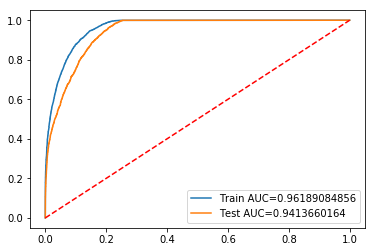

In [88]:
# output the AUC and accuracy for the model
y_pred_proba_test = clf.predict_proba(X_test)[::,1]
y_pred_proba_train = clf.predict_proba(X_train)[::,1]
fpr_test, tpr_test, _ = roc_curve(y_test,  y_pred_proba_test)
fpr_train, tpr_train, _ = roc_curve(y_train,  y_pred_proba_train)
auc = roc_auc_score(y_test, y_pred_proba_test)
auc2 = roc_auc_score(y_train, y_pred_proba_train)
plt.plot(fpr_train,tpr_train,label="Train AUC="+str(auc2))
plt.plot(fpr_test,tpr_test,label="Test AUC="+str(auc))
plt.plot([0,1],'r--')
plt.legend(loc=4)
plt.show()

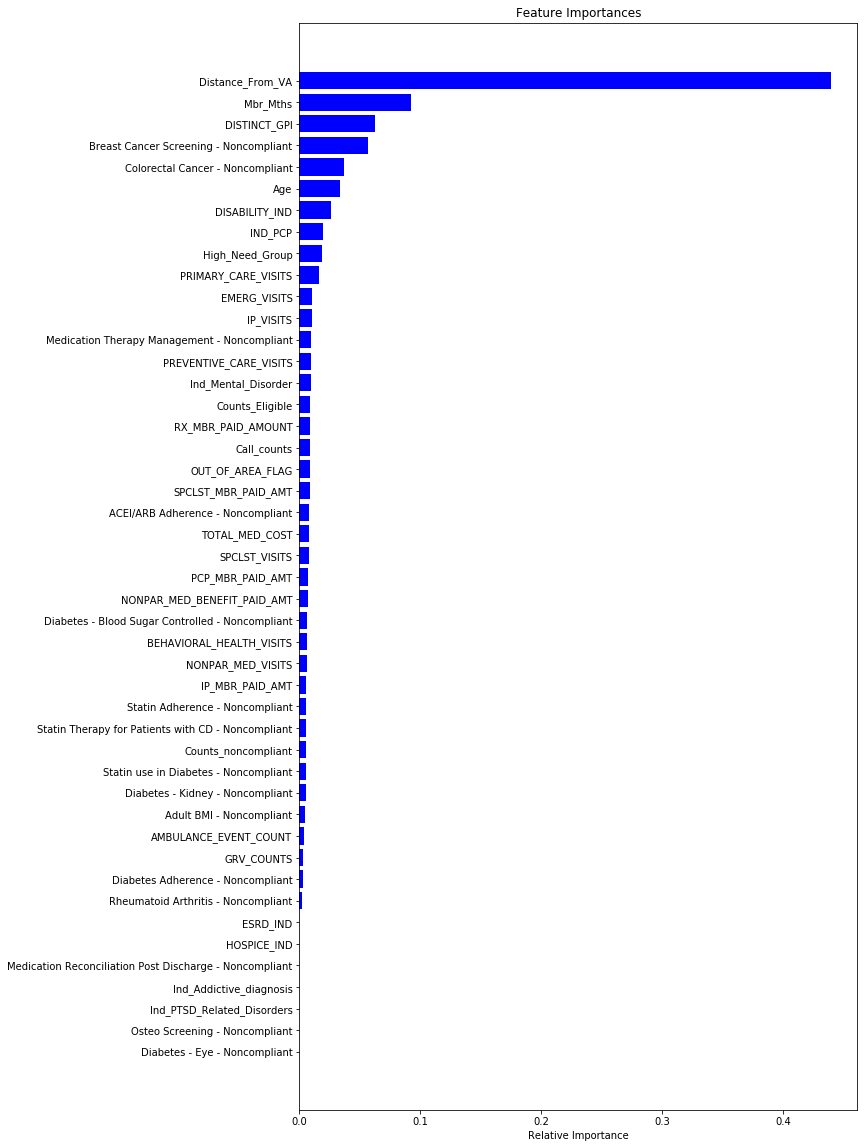

In [89]:
# output the top variables based on the importance
features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,20))
plt.title('Feature Importances')
plt.barh(range(X_train.shape[1]), importances[indices][-X_train.shape[1]:], color='b', align='center')
plt.yticks(range(X_train.shape[1]), features[indices][-X_train.shape[1]:])
plt.xlabel('Relative Importance')
plt.show()

In [90]:
# output top 20 variables importance list
var_list=zip(X_train.columns,clf.feature_importances_)
importance_df=pd.DataFrame(list(var_list),columns=['Variable','Importance']).sort_values(['Importance'], ascending=False)
pd.set_option('display.max_rows',200)
importance_df.head(50)

,Variable,Importance
33,Distance_From_VA,0.4396685
0,Mbr_Mths,0.0925195
43,DISTINCT_GPI,0.0622438
19,Breast Cancer Screening - Noncompliant,0.0565338
20,Colorectal Cancer - Noncompliant,0.0365123
1,Age,0.0336108
39,DISABILITY_IND,0.0263621
15,IND_PCP,0.0196601
36,High_Need_Group,0.0186185
3,PRIMARY_CARE_VISITS,0.0162786


In [91]:
decile_df=decile(clf,X_test,y_test)
decile_df['Expected']=round(decile_df['Population']*0.2328271,0)
decile_df['Expected Rate']=0.2328271
decile_df

Target,Zero,Ones,Population,TargetRate,CumulativeTargetRate,TargetsCaptured,Expected,Expected Rate
Deciles,,,,,,,,
1,114.0,1031.0,1145.0,0.9004367,0.9004367,0.3851326,267.0,0.2328271
2,453.0,692.0,1145.0,0.6043668,0.7524017,0.6436309,267.0,0.2328271
3,608.0,537.0,1145.0,0.4689956,0.6579330,0.8442286,267.0,0.2328271
4,788.0,356.0,1144.0,0.3111888,0.5713038,0.9772133,266.0,0.2328271
5,1084.0,61.0,1145.0,0.0532751,0.4676799,1.0000000,267.0,0.2328271
6,1145.0,0.0,1145.0,0.0000000,0.3897219,1.0000000,267.0,0.2328271
7,1144.0,0.0,1144.0,0.0000000,0.3340821,1.0000000,266.0,0.2328271
8,1145.0,0.0,1145.0,0.0000000,0.2923127,1.0000000,267.0,0.2328271
9,1145.0,0.0,1145.0,0.0000000,0.2598272,1.0000000,267.0,0.2328271


In [92]:
from sklearn.metrics import confusion_matrix
y_pred=clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[7957,  814],
       [ 725, 1952]], dtype=int64)

In [93]:
# fit logistic model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
new_X=Active_members[importance_df.Variable.values].fillna(0)
new_y=Active_members['target']
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, random_state=1859, test_size=0.3)
logit_model = LogisticRegression(max_iter=1000).fit(new_X_train,new_y_train)

In [94]:
# output coefficients
variable=pd.DataFrame(new_X_train.columns).rename(columns={0:'Variable'})
coef=pd.DataFrame(logit_model.coef_).transpose().rename(columns={0:'Coef'})
odds=pd.DataFrame(np.exp(logit_model.coef_)).transpose().rename(columns={0:'Odds Ratio'})
Logit_output=pd.concat([variable,coef,odds], axis=1)
Logit_output.merge(importance_df, how='left', left_on='Variable', right_on='Variable')

,Variable,Coef,Odds Ratio,Importance
0,Distance_From_VA,0.0760239,1.0789883,0.4396685
1,Mbr_Mths,-0.0128890,0.9871937,0.0925195
2,DISTINCT_GPI,-0.1415522,0.8680099,0.0622438
3,Breast Cancer Screening - Noncompliant,-0.7235557,0.4850246,0.0565338
4,Colorectal Cancer - Noncompliant,0.5872710,1.7990720,0.0365123
5,Age,0.0432756,1.0442256,0.0336108
6,DISABILITY_IND,0.3480526,1.4163067,0.0263621
7,IND_PCP,-0.4275537,0.6521024,0.0196601
8,High_Need_Group,0.5411213,1.7179322,0.0186185
9,PRIMARY_CARE_VISITS,-0.0399067,0.9608791,0.0162786


In [95]:
Logit_output.merge(importance_df, how='left', left_on='Variable', right_on='Variable').to_csv('importance.csv')

In [96]:
import statsmodels.api as sm
model = sm.OLS(new_y_train,new_X_train)
stats_clf = model.fit()
stats_clf.summary2()

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Results: Ordinary least squares
========================================================================================================
Model:                           OLS                          Adj. R-squared:                 0.328     
Dependent Variable:              target                       AIC:                            27155.3291
Date:                            2020-09-24 19:51             BIC:                            27532.1959
No. Observations:                26709                        Log-Likelihood:                 -13532.   
Df Model:                        46                           F-statistic:                    284.4     
Df Residuals:                    26663                        Prob (F-statistic):             0.00      
R-squared:                       0.329                        Scale:                          0.16156   
--------------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------------------------------------
Distance_From_VA                                         0.0008   0.0000  17.3139 0.0000  0.0007  0.0009
Mbr_Mths                                                -0.0019   0.0002  -8.5897 0.0000 -0.0023 -0.0015
DISTINCT_GPI                                            -0.0189   0.0008 -22.6761 0.0000 -0.0206 -0.0173
Breast Cancer Screening - Noncompliant                  -0.1093   0.0078 -14.0047 0.0000 -0.1245 -0.0940
Colorectal Cancer - Noncompliant                         0.0692   0.0069  10.1035 0.0000  0.0558  0.0827
Age                                                      0.0075   0.0003  21.7978 0.0000  0.0068  0.0082
DISABILITY_IND                                           0.0878   0.0079  11.1734 0.0000  0.0724  0.1032
IND_PCP                                                 -0.1200   0.0109 -10.9709 0.0000 -0.1414 -0.0986
High_Need_Group                                          0.0776   0.0077  10.1238 0.0000  0.0625  0.0926
PRIMARY_CARE_VISITS                                     -0.0062   0.0012  -5.2877 0.0000 -0.0085 -0.0039
EMERG_VISITS                                             0.0122   0.0050   2.4264 0.0153  0.0023  0.0220
IP_VISITS                                                0.0023   0.0016   1.4709 0.1413 -0.0008  0.0054
Medication Therapy Management - Noncompliant             0.0461   0.0100   4.6039 0.0000  0.0265  0.0657
PREVENTIVE_CARE_VISITS                                  -0.0435   0.0073  -5.9545 0.0000 -0.0578 -0.0292
Ind_Mental_Disorder                                     -0.0212   0.0074  -2.8640 0.0042 -0.0357 -0.0067
Counts_Eligible                                         -0.0275   0.0039  -7.1282 0.0000 -0.0350 -0.0199
RX_MBR_PAID_AMOUNT                                      -0.0000   0.0000  -2.4299 0.0151 -0.0000 -0.0000
Call_counts                                              0.0017   0.0004   4.6536 0.0000  0.0010  0.0025
OUT_OF_AREA_FLAG                                         0.0423   0.0145   2.9136 0.0036  0.0139  0.0708
SPCLST_MBR_PAID_AMT                                     -0.0000   0.0000  -3.2107 0.0013 -0.0001 -0.0000
ACEI/ARB Adherence - Noncompliant                       -0.0086   0.0064  -1.3279 0.1842 -0.0212  0.0041
TOTAL_MED_COST                                           0.0000   0.0000   2.0021 0.0453  0.0000  0.0000
SPCLST_VISITS                                            0.0015   0.0006   2.4554 0.0141  0.0003  0.0027
PCP_MBR_PAID_AMT                                        -0.0001   0.0000  -2.0649 0.0389 -0.0001 -0.0000
NONPAR_MED_BENEFIT_PAID_AMT                             -0.0000   0.0000  -1.1403 0.2542 -0.0000  0.0000
Diabetes - Blood Sugar Controlled - Noncompliant         0.0504   0.0144   3.4987 0.0005  0.0222  0.078

<font color='green'>**-----------------------------------------------Part 17:  Revised Model. -----------------------------------**</font>

In [97]:
not_significant=['RX_MBR_PAID_AMOUNT','AMBULANCE_EVENT_COUNT','NONPAR_MED_BENEFIT_PAID_AMT','NONPAR_MED_VISITS',
                 'Rheumatoid Arthritis - Noncompliant','Statin use in Diabetes - Noncompliant',
                 'Medication Reconciliation Post Discharge - Noncompliant','HOSPICE_IND','ESRD_IND',
                 'Osteo Screening - Noncompliant']
X_new=X.drop(not_significant, axis=1)
y_new=Active_members['target']
new_X_train_2, new_X_test_2, new_y_train_2, new_y_test_2 = train_test_split(X_new, y_new, random_state=1859, test_size=0.3)

In [98]:
# fit the model
clf= XGBClassifier(random_state = 50,n_jobs=-1,max_depth=3,n_estimators = 400,learning_rate = 0.1, min_child_weight = 4)
clf.fit(new_X_train_2, new_y_train_2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=4, missing=None,
       n_estimators=400, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=50, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

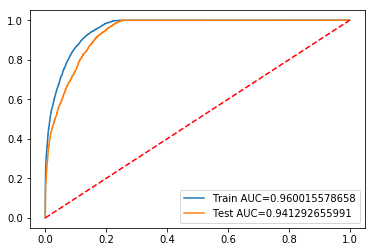

In [99]:
# output the AUC and accuracy for the model
y_pred_proba_test = clf.predict_proba(new_X_test_2)[::,1]
y_pred_proba_train = clf.predict_proba(new_X_train_2)[::,1]
fpr_test, tpr_test, _ = roc_curve(new_y_test_2,  y_pred_proba_test)
fpr_train, tpr_train, _ = roc_curve(new_y_train_2,  y_pred_proba_train)
auc = roc_auc_score(new_y_test_2, y_pred_proba_test)
auc2 = roc_auc_score(new_y_train_2, y_pred_proba_train)
plt.plot(fpr_train,tpr_train,label="Train AUC="+str(auc2))
plt.plot(fpr_test,tpr_test,label="Test AUC="+str(auc))
plt.plot([0,1],'r--')
plt.legend(loc=4)
plt.show()

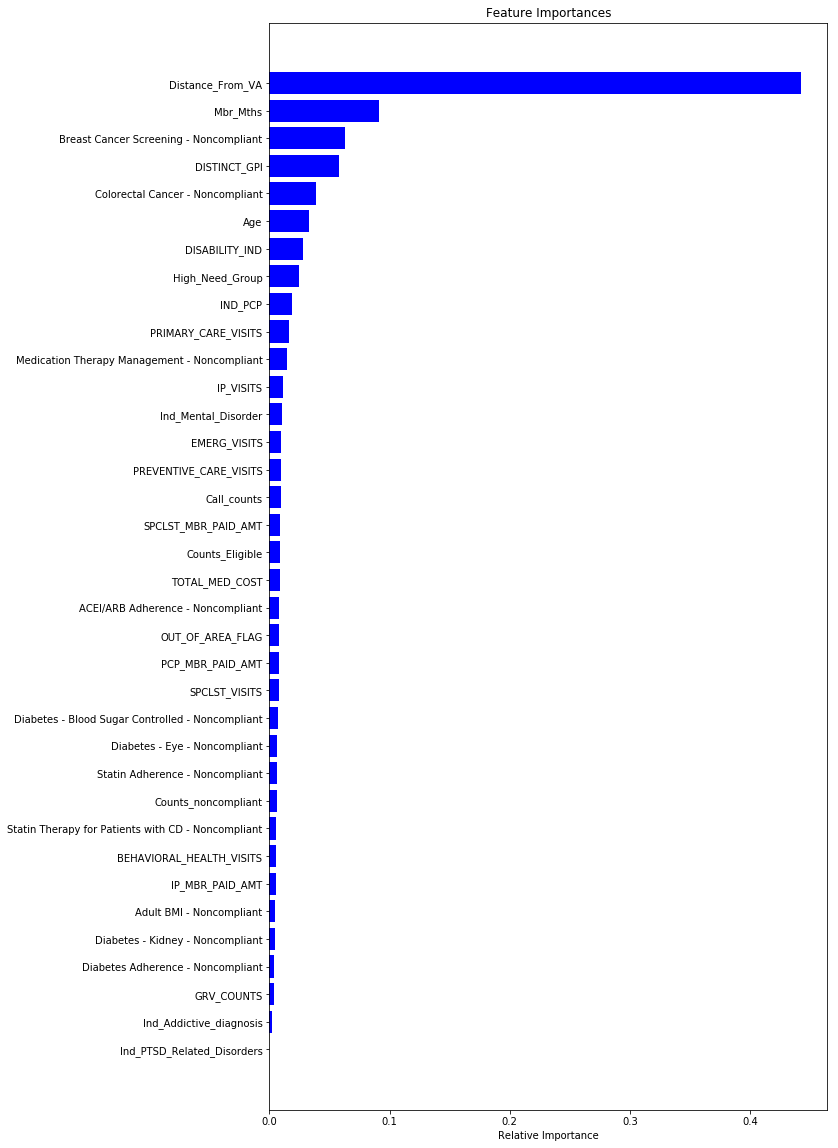

In [100]:
# output the top variables based on the importance
features = new_X_train_2.columns
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,20))
plt.title('Feature Importances')
plt.barh(range(new_X_train_2.shape[1]), importances[indices][-new_X_train_2.shape[1]:], color='b', align='center')
plt.yticks(range(new_X_train_2.shape[1]), features[indices][-new_X_train_2.shape[1]:])
plt.xlabel('Relative Importance')
plt.show()

In [101]:
# output top 20 variables importance list
var_list=zip(new_X_train_2.columns,clf.feature_importances_)
importance_df=pd.DataFrame(list(var_list),columns=['Variable','Importance']).sort_values(['Importance'], ascending=False)
pd.set_option('display.max_rows',200)
importance_df.head(50)

,Variable,Importance
26,Distance_From_VA,0.4422371
0,Mbr_Mths,0.0907914
16,Breast Cancer Screening - Noncompliant,0.0628134
33,DISTINCT_GPI,0.0580976
17,Colorectal Cancer - Noncompliant,0.0385585
1,Age,0.0329705
31,DISABILITY_IND,0.0275648
29,High_Need_Group,0.0249486
12,IND_PCP,0.0188948
3,PRIMARY_CARE_VISITS,0.0162998


In [102]:
decile_df=decile(clf,new_X_test_2,new_y_test_2)
decile_df['Expected']=round(decile_df['Population']*0.2328271,0)
decile_df['Expected Rate']=0.2328271
decile_df

Target,Zero,Ones,Population,TargetRate,CumulativeTargetRate,TargetsCaptured,Expected,Expected Rate
Deciles,,,,,,,,
1,119.0,1026.0,1145.0,0.8960699,0.8960699,0.3832648,267.0,0.2328271
2,451.0,694.0,1145.0,0.6061135,0.7510917,0.6425103,267.0,0.2328271
3,606.0,539.0,1145.0,0.4707424,0.6576419,0.8438551,267.0,0.2328271
4,782.0,362.0,1144.0,0.3164336,0.5723957,0.9790811,266.0,0.2328271
5,1089.0,56.0,1145.0,0.0489083,0.4676799,1.0000000,267.0,0.2328271
6,1145.0,0.0,1145.0,0.0000000,0.3897219,1.0000000,267.0,0.2328271
7,1144.0,0.0,1144.0,0.0000000,0.3340821,1.0000000,266.0,0.2328271
8,1145.0,0.0,1145.0,0.0000000,0.2923127,1.0000000,267.0,0.2328271
9,1145.0,0.0,1145.0,0.0000000,0.2598272,1.0000000,267.0,0.2328271


In [103]:
# fit logistic model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
new_X_train_2=new_X_train_2.fillna(0)
logit_model_2 = LogisticRegression(max_iter=1000).fit(new_X_train_2,new_y_train_2)

In [104]:
# output coefficients
variable=pd.DataFrame(new_X_train_2.columns).rename(columns={0:'Variable'})
coef=pd.DataFrame(logit_model_2.coef_).transpose().rename(columns={0:'Coef'})
odds=pd.DataFrame(np.exp(logit_model.coef_)).transpose().rename(columns={0:'Odds Ratio'})
Logit_output=pd.concat([variable,coef,odds], axis=1)
Logit_output.merge(importance_df, how='left', left_on='Variable', right_on='Variable').sort_values(by=['Importance'], ascending=False)

,Variable,Coef,Odds Ratio,Importance
26,Distance_From_VA,0.0752085,0.9798258,0.4422371
0,Mbr_Mths,-0.0136166,1.0789883,0.0907914
16,Breast Cancer Screening - Noncompliant,-0.7672737,0.9998851,0.0628134
33,DISTINCT_GPI,-0.1480811,1.3843214,0.0580976
17,Colorectal Cancer - Noncompliant,0.6530374,1.0118043,0.0385585
1,Age,0.0414104,0.9871937,0.0329705
31,DISABILITY_IND,0.3649103,0.7988011,0.0275648
29,High_Need_Group,0.5685821,1.2492392,0.0249486
12,IND_PCP,-0.4932335,1.3436538,0.0188948
3,PRIMARY_CARE_VISITS,-0.0467228,0.4850246,0.0162998


In [105]:
print(Active_members[Active_members['target']==1].CMS_State.value_counts(normalize=True))
print(Active_members[Active_members['target']==1].Gender.value_counts(normalize=True))
print(Active_members[Active_members['target']==1].Mbr_Mths.value_counts(normalize=True))
print(Active_members[Active_members['target']==1].Age.value_counts(normalize=True))

FL    0.1023302
NY    0.0629809
NC    0.0572653
OH    0.0556166
TX    0.0538580
IL    0.0527588
PA    0.0518795
GA    0.0501209
SC    0.0428666
MO    0.0406683
IA    0.0397890
NJ    0.0396791
AZ    0.0333040
CT    0.0282480
KS    0.0234117
IN    0.0228622
MI    0.0214333
NV    0.0187953
CA    0.0185755
ME    0.0175863
WI    0.0173665
LA    0.0157177
VA    0.0153880
MA    0.0134095
TN    0.0109914
UT    0.0108815
NE    0.0105518
AL    0.0094526
CO    0.0091229
AR    0.0090130
DE    0.0062651
ID    0.0056056
OK    0.0052759
WA    0.0047263
WV    0.0042867
KY    0.0038470
SD    0.0035173
NM    0.0034073
MS    0.0034073
OR    0.0013190
NH    0.0010991
DC    0.0004397
WY    0.0003297
MD    0.0002198
RI    0.0002198
MN    0.0001099
Name: CMS_State, dtype: float64
1    0.9313036
0    0.0686964
Name: Gender, dtype: float64
9      0.6730051
21     0.0998022
8      0.0457243
7      0.0350627
6      0.0283579
4      0.0138492
5      0.0101121
18     0.0078039
33     0.0076940
19     0.0071444
20 

<font color='green'>**-----------------------------------------------Part 18:  Persist Model. -----------------------------------**</font>

In [106]:
# persist Model to a permenent location
import pickle
filename = 'Final_model.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [107]:
X_train.columns

Index(['Mbr_Mths', 'Age', 'EMERG_VISITS', 'PRIMARY_CARE_VISITS', 'SPCLST_VISITS', 'IP_VISITS',
       'PREVENTIVE_CARE_VISITS', 'PCP_MBR_PAID_AMT', 'SPCLST_MBR_PAID_AMT', 'IP_MBR_PAID_AMT',
       'NONPAR_MED_VISITS', 'NONPAR_MED_BENEFIT_PAID_AMT', 'TOTAL_MED_COST',
       'AMBULANCE_EVENT_COUNT', 'BEHAVIORAL_HEALTH_VISITS', 'IND_PCP', 'Counts_Eligible',
       'Counts_noncompliant', 'Adult BMI - Noncompliant', 'Breast Cancer Screening - Noncompliant',
       'Colorectal Cancer - Noncompliant', 'Diabetes - Blood Sugar Controlled - Noncompliant',
       'Diabetes - Eye - Noncompliant', 'Diabetes - Kidney - Noncompliant',
       'Osteo Screening - Noncompliant', 'Rheumatoid Arthritis - Noncompliant',
       'Statin Therapy for Patients with CD - Noncompliant',
       'Medication Reconciliation Post Discharge - Noncompliant',
       'Medication Therapy Management - Noncompliant', 'ACEI/ARB Adherence - Noncompliant',
       'Diabetes Adherence - Noncompliant', 'Statin Adherence - Noncompli